In [ ]:
# FIX: Ensure compatible torch and torchvision versions
!pip install --upgrade torch torchvision --quiet
print("✅ Torch and TorchVision versions synchronized.")


✅ Torch and TorchVision versions synchronized.


# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## Step 1: Setting Up Our Tools
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [ ]:
# Step 1: Install required packages
%pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids

# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU (for students to verify)
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU. Consider using Google Colab with GPU enabled.")

Package installation complete.
We'll be using: cuda
GPU name: Tesla T4
GPU memory: 15.83 GB



###  REPRODUCIBILITY AND DEVICE SETUP

In [ ]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")

Random seeds set to 42 for reproducible results
Available GPU Memory: 15.8 GB


## Step 2: Choosing Your Dataset

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

In [ ]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab or basic GPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the MNIST dataset
# Hint: Use torchvision.datasets.MNIST with root='./data', train=True,
#       transform=transform, and download=True
# Then print a success message

# Enter your code here:
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
print("✓ MNIST dataset loaded successfully.")


#-------------------------------------------
# OPTION 2: Fashion-MNIST (Intermediate - 2GB GPU)
#-------------------------------------------
# Uncomment this section to use Fashion-MNIST instead
"""
IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the Fashion-MNIST dataset
# Hint: Very similar to MNIST but use torchvision.datasets.FashionMNIST

# Enter your code here:

"""

#-------------------------------------------
# OPTION 3: CIFAR-10 (Advanced - 4GB+ GPU)
#-------------------------------------------
# Uncomment this section to use CIFAR-10 instead
"""
IMG_SIZE = 32
IMG_CH = 3
N_CLASSES = 10
BATCH_SIZE = 32  # Reduced batch size for memory
EPOCHS = 50      # More epochs for complex data

# Your code to create the transform and load CIFAR-10
# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Then load torchvision.datasets.CIFAR10

# Enter your code here:

"""

✓ MNIST dataset loaded successfully.


'\nIMG_SIZE = 32\nIMG_CH = 3\nN_CLASSES = 10\nBATCH_SIZE = 32  # Reduced batch size for memory\nEPOCHS = 50      # More epochs for complex data\n\n# Your code to create the transform and load CIFAR-10\n# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n# Then load torchvision.datasets.CIFAR10\n\n# Enter your code here:\n\n'

In [ ]:
#Validating Dataset Selection
#Let's add code to validate that a dataset was selected
# and check if your GPU has enough memory:

# Validate dataset selection
if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)

# Your code to validate GPU memory requirements
# Hint: Check torch.cuda.is_available() and use torch.cuda.get_device_properties(0).total_memory
# to get available GPU memory, then compare with dataset requirements

# Enter your code here:
if device.type == 'cuda':
    try:
        gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
        gpu_memory_gb = gpu_memory_bytes / (1024**3)
        print(f"Available GPU Memory: {gpu_memory_gb:.2f} GB")

        # Define minimum required memory based on dataset selected
        if 'MNIST' in type(dataset).__name__ or 'FashionMNIST' in type(dataset).__name__:
            required_memory_gb = 2
        elif 'CIFAR10' in type(dataset).__name__:
            required_memory_gb = 4
        # Add more dataset options here as needed (e.g., CelebA)
        # elif 'CelebA' in type(dataset).__name__:
        #     required_memory_gb = 8
        else:
            required_memory_gb = 4 # Default conservative estimate

        if gpu_memory_gb < required_memory_gb:
            print(f"⚠️ Warning: Your GPU has {gpu_memory_gb:.2f} GB memory, but {type(dataset).__name__} recommends at least {required_memory_gb} GB.")
            print("Consider reducing BATCH_SIZE or switching to a smaller dataset if you encounter out-of-memory errors.")
        else:
             print(f"✓ Sufficient GPU memory ({gpu_memory_gb:.2f} GB) for {type(dataset).__name__} ({required_memory_gb} GB recommended).")

    except Exception as e:
        print(f"Could not check GPU memory requirements: {e}")
else:
    print("No GPU detected. Memory check skipped.")

Available GPU Memory: 14.74 GB
✓ Sufficient GPU memory (14.74 GB) for MNIST (2 GB recommended).


In [ ]:
#Dataset Properties and Data Loaders
#Now let's examine our dataset
#and set up the data loaders:

# Your code to check sample batch properties
# Hint: Get a sample batch using next(iter(DataLoader(dataset, batch_size=1)))
# Then print information about the dataset shape, type, and value ranges

# Enter your code here:
sample_batch = next(iter(DataLoader(dataset, batch_size=1)))
print("\nDataset properties check:")
print(f"Sample batch shape: {sample_batch[0].shape}")
print(f"Sample data type: {sample_batch[0].dtype}")
print(f"Sample min value: {sample_batch[0].min().item():.2f}")
print(f"Sample max value: {sample_batch[0].max().item():.2f}")


#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
# Create train-validation split

# Your code to create a train-validation split (80% train, 20% validation)
# Hint: Use random_split() with appropriate train_size and val_size
# Be sure to use a fixed generator for reproducibility

# Enter your code here:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(SEED) # Use fixed seed for reproducibility
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=generator)
print(f"Dataset split: {len(train_dataset)} training samples, {len(val_dataset)} validation samples.")

# Your code to create dataloaders for training and validation
# Hint: Use DataLoader with batch_size=BATCH_SIZE, appropriate shuffle settings,
# and num_workers based on available CPU cores

# Enter your code here:
num_workers = os.cpu_count() // 2 if os.cpu_count() else 0 # Use half available CPU cores
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print(f"Dataloaders created with batch size {BATCH_SIZE} and {num_workers} workers.")


Dataset properties check:
Sample batch shape: torch.Size([1, 1, 28, 28])
Sample data type: torch.float32
Sample min value: -1.00
Sample max value: 1.00
Dataset split: 48000 training samples, 12000 validation samples.
Dataloaders created with batch size 64 and 1 workers.


## Step 3: Building Our Model Components

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [ ]:
# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            # Adjust group_size to be compatible
            group_size = min(group_size, out_ch)
            while group_size > 1 and out_ch % group_size != 0:
                group_size -= 1
            if out_ch % group_size != 0: # Fallback to instance norm if cannot find a group_size
                group_size = 1
            print(f"Adjusted group_size to {group_size}")


        # Your code to create layers for the block
        # Hint: Use nn.Conv2d, nn.GroupNorm, and nn.GELU activation
        # Then combine them using nn.Sequential

        # Enter your code here:
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Simply pass the input through the model

        # Enter your code here:
        return self.model(x)

In [ ]:
# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Your code to create the rearrange operation and convolution
        # Hint: Use Rearrange from einops.layers.torch to reshape pixels
        # Then add a GELUConvBlock to process the rearranged tensor

        # Enter your code here:
        self.model = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2),
            GELUConvBlock(in_chs * 4, in_chs, group_size)
        )


    def forward(self, x):
        # Your code for the forward pass
        # Hint: Apply rearrange to downsample, then apply convolution

        # Enter your code here:
        return self.model(x)

In [ ]:
class DownBlock(nn.Module):
    """
    Downsampling block for encoding path in U-Net architecture.

    This block:
    1. Processes input features with two convolutional blocks
    2. Downsamples spatial dimensions by 2x using pixel rearrangement

    Args:
        in_chs (int): Number of input channels
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)
        self.pool = RearrangePoolBlock(out_chs, group_size)

        # Log the configuration for debugging
        print(f"Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        """
        Forward pass through the DownBlock.

        Args:
            x (torch.Tensor): Input tensor of shape [B, in_chs, H, W]

        Returns:
            tuple: (pooled_output, skip_output)
                - pooled_output (torch.Tensor): Output tensor of shape [B, out_chs, H/2, W/2] for next down layer
                - skip_output (torch.Tensor): Output tensor of shape [B, out_chs, H, W] for skip connection
        """
        x = self.conv1(x)
        x_skip = self.conv2(x) # This is the feature map to be used as a skip connection
        x_down = self.pool(x_skip) # This is the output that goes to the next down block
        return x_down, x_skip

In [ ]:
#Now let's implement the upsampling block for our U-Net architecture:
class UpBlock(nn.Module):
    """
    Upsampling block for decoding path in U-Net architecture.

    This block:
    1. Takes features from the decoding path and corresponding skip connection
    2. Concatenates them along the channel dimension
    3. Upsamples spatial dimensions by 2x using transposed convolution
    4. Processes features through multiple convolutional blocks

    Args:
        in_chs (int): Number of input channels from the previous layer
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()

        # Your code to create the upsampling operation
        # Hint: Use nn.ConvTranspose2d with kernel_size=2 and stride=2
        # Note that the input channels will be 2 * in_chs due to concatenation

        # Enter your code here:
        # The transposed convolution should take 'in_chs' and output 'in_chs'
        self.upsample = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)

        # Your code to create the convolutional blocks
        # Hint: Use multiple GELUConvBlocks in sequence

        # Enter your code here:
        # The first conv block takes 2*in_chs after concatenation
        self.conv_blocks = nn.Sequential(
            GELUConvBlock(2 * in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )


        # Log the configuration for debugging
        print(f"Created UpBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x")

    def forward(self, x, skip):
        """
        Forward pass through the UpBlock.

        Args:
            x (torch.Tensor): Input tensor from previous layer [B, in_chs, H, W]
            skip (torch.Tensor): Skip connection tensor from encoder [B, in_chs, 2H, 2W]

        Returns:
            torch.Tensor: Output tensor with shape [B, out_chs, 2H, 2W]
        """
        # Your code for the forward pass
        # Hint: Concatenate x and skip, then upsample and process

        # Enter your code here:
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv_blocks(x)
        return x

In [ ]:
# Here we implement the time embedding block for our U-Net architecture:
# Helps the model understand time steps in diffusion process
class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in diffusion process.

    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.

    Args:
        dim (int): Embedding dimension
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Computes sinusoidal embeddings for given time steps.

        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]

        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



In [ ]:
# Helps the model understand which number/image to draw (class conditioning)
class EmbedBlock(nn.Module):
    """
    Creates embeddings for class conditioning in diffusion models.

    This module transforms a one-hot or index representation of a class
    into a rich embedding that can be added to feature maps.

    Args:
        input_dim (int): Input dimension (typically number of classes)
        emb_dim (int): Output embedding dimension
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim

        # Your code to create the embedding layers
        # Hint: Use nn.Linear layers with a GELU activation, followed by
        # nn.Unflatten to reshape for broadcasting with feature maps

        # Enter your code here:
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            Rearrange('b c -> b c 1 1')
        )


    def forward(self, x):
        """
        Computes class embeddings for the given class indices.

        Args:
            x (torch.Tensor): Class indices or one-hot encodings [batch_size, input_dim]

        Returns:
            torch.Tensor: Class embeddings of shape [batch_size, emb_dim, 1, 1]
                          (ready to be added to feature maps)
        """
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [ ]:
# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.

    This architecture follows the standard U-Net design with:
    1. Downsampling path that reduces spatial dimensions
    2. Middle processing blocks
    3. Upsampling path that reconstructs spatial dimensions
    4. Skip connections between symmetric layers

    The model is conditioned on:
    - Time step (where we are in the diffusion process)
    - Class labels (what we want to generate)

    Args:
        T (int): Number of diffusion time steps
        img_ch (int): Number of image channels
        img_size (int): Size of input images
        down_chs (list): Channel dimensions for each level of U-Net
        t_embed_dim (int): Dimension for time embeddings
        c_embed_dim (int): Dimension for class embeddings
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        self.img_ch = img_ch
        self.img_size = img_size
        self.down_chs = down_chs
        self.t_embed_dim = t_embed_dim
        self.c_embed_dim = c_embed_dim
        self.T = T
        self.group_size = 8 # You might adjust this based on your channel sizes

        # Your code to create the time embedding
        # Hint: Use SinusoidalPositionEmbedBlock, nn.Linear, and nn.GELU in sequence

        # Enter your code here:
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, down_chs[-1]), # Project time embedding to match middle block channels
            nn.GELU(),
            nn.Linear(down_chs[-1], down_chs[-1])
        )

        # Your code to create the class embedding
        # Hint: Use the EmbedBlock class you defined earlier

        # Enter your code here:
        # Modify EmbedBlock to output directly to the channel dimension of the middle block
        # or adjust the forward pass to handle the projection
        self.class_embed = EmbedBlock(N_CLASSES, down_chs[-1]) # Project class embedding to match middle block channels

        # Your code to create the initial convolution
        # Hint: Use GELUConvBlock to process the input image

        # Enter your code here:
        self.initial_conv = GELUConvBlock(img_ch, down_chs[0], self.group_size)

        # Your code to create the downsampling path
        # Hint: Use nn.ModuleList with DownBlock for each level

        # Enter your code here:
        self.downs = nn.ModuleList([])
        for i in range(len(down_chs) - 1):
            self.downs.append(DownBlock(down_chs[i], down_chs[i+1], self.group_size))


        # Your code to create the middle blocks
        # Hint: Use GELUConvBlock twice to process features at lowest resolution

        # Enter your code here:
        self.middle = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], self.group_size),
            GELUConvBlock(down_chs[-1], down_chs[-1], self.group_size)
        )

        # Your code to create the upsampling path
        # Hint: Use nn.ModuleList with UpBlock for each level (in reverse order)

        # Enter your code here:
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(down_chs) - 1)):
             self.ups.append(UpBlock(down_chs[i+1], down_chs[i], self.group_size))

        # Your code to create the final convolution
        # Hint: Use nn.Conv2d to project back to the original image channels

        # Enter your code here:
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=3, padding=1)


        print(f"Created UNet with {len(down_chs)} scale levels")
        print(f"Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.

        Args:
            x (torch.Tensor): Input noisy image [B, img_ch, H, W]
            t (torch.Tensor): Diffusion time steps [B]
            c (torch.Tensor): Class labels [B, c_embed_dim]
            c_mask (torch.Tensor): Mask for conditional generation [B, 1]

        Returns:
            torch.Tensor: Predicted noise in the input image [B, img_ch, H, W]
        """
        # Time embedding
        t_embed = self.time_embed(t)
        t_embed = rearrange(t_embed, 'b c -> b c 1 1')

        # Class embedding
        c_embed = self.class_embed(c)
        c_embed = c_embed * c_mask

        # Initial feature extraction
        x = self.initial_conv(x)

        # Collect skip connections from the downsampling path
        skips = []
        for i, down_block in enumerate(self.downs):
            x_downsampled, x_skip_output = down_block(x)
            skips.append(x_skip_output)
            x = x_downsampled

        # Middle processing and conditioning
        x = self.middle(x)
        x = x + t_embed + c_embed

        # Upsampling path with skip connections
        # The skips were appended in order from outermost to innermost down block.
        # So, we pop them from the end to match with the upsampling path in reverse order.
        for i, up_block in enumerate(self.ups):
            skip_conn = skips.pop()
            x = up_block(x, skip_conn)

        # Final projection
        output = self.final_conv(x)

        return output

## Step 4: Setting Up The Diffusion Process

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [ ]:
# Set up the noise schedule
n_steps = 100  # How many steps to go from clear image to noise
beta_start = 0.0001  # Starting noise level (small)
beta_end = 0.02      # Ending noise level (larger)

# Create schedule of gradually increasing noise levels
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)

# Calculate important values used in diffusion equations
alpha = 1 - beta  # Portion of original image to keep at each step
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product of alphas
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # For scaling the original image
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)  # For scaling the noise

# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.

    The formula is: x_t = √(α_bar_t) * x_0 + √(1-α_bar_t) * ε
    where ε is random noise and α_bar_t is the cumulative product of (1-β).

    Args:
        x_0 (torch.Tensor): Original clean image [B, C, H, W]
        t (torch.Tensor): Timestep indices indicating noise level [B]

    Returns:
        tuple: (noisy_image, noise_added)
            - noisy_image is the image with noise added
            - noise_added is the actual noise that was added (for training)
    """
    # Create random Gaussian noise with same shape as image
    noise = torch.randn_like(x_0)

    # Get noise schedule values for the specified timesteps
    # Reshape to allow broadcasting with image dimensions
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    # Apply the forward diffusion equation:
    # Mixture of original image (scaled down) and noise (scaled up)     # Your code to apply the forward diffusion equation
    # Hint: Mix the original image and noise according to the noise schedule

    # Enter your code here:
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise




    return x_t, noise

# Function to remove noise from images (reverse diffusion process)
@torch.no_grad()  # Don't track gradients during sampling (inference only)
def remove_noise(x_t, t, model, c, c_mask):
    """
    Remove noise from images using the learned reverse diffusion process.

    This implements a single step of the reverse diffusion sampling process.
    The model predicts the noise in the image, which we then use to partially
    denoise the image.

    Args:
        x_t (torch.Tensor): Noisy image at timestep t [B, C, H, W]
        t (torch.Tensor): Current timestep indices [B]
        model (nn.Module): U-Net model that predicts noise
        c (torch.Tensor): Class conditioning (what digit to generate) [B, C]
        c_mask (torch.Tensor): Mask for conditional generation [B, 1]

    Returns:
        torch.Tensor: Less noisy image for the next timestep [B, C, H, W]
    """
    # Predict the noise in the image using our model
    predicted_noise = model(x_t, t, c, c_mask)

    # Get noise schedule values for the current timestep
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1) # <--- Added this line

    # Special case: if we're at the first timestep (t=0), we're done
    if t[0] == 0:
        return x_t
    else:
        # Calculate the mean of the denoised distribution
        # This is derived from Bayes' rule and the diffusion process equations
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )

        # Add a small amount of random noise (variance depends on timestep)
        # This helps prevent the generation from becoming too deterministic
        noise = torch.randn_like(x_t)

        # Return the partially denoised image with a bit of new random noise
        return mean + torch.sqrt(beta_t) * noise

In [ ]:
# This cell is no longer needed as the functions have been moved to the previous cell.

In [ ]:
# This cell is no longer needed as the functions have been moved to the previous cell.

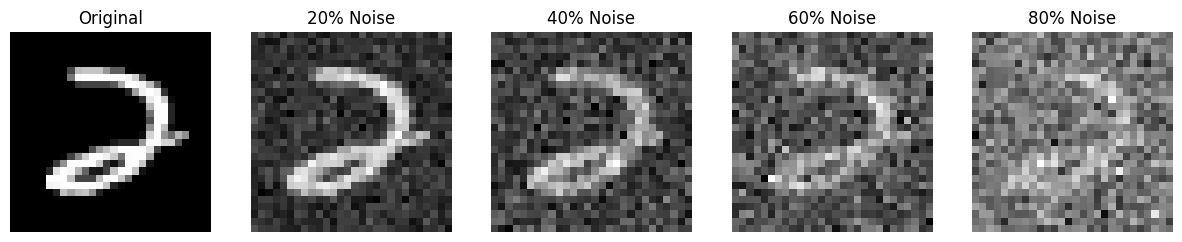

'\n# Try a non-linear noise schedule\nbeta_alt = torch.linspace(beta_start, beta_end, n_steps)**2\nalpha_alt = 1 - beta_alt\nalpha_bar_alt = torch.cumprod(alpha_alt, dim=0)\n# How would this affect the diffusion process?\n'

In [ ]:
# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.

    Args:
        image (torch.Tensor): Original clean image [C, H, W]
        num_steps (int): Number of noise levels to show
    """
    plt.figure(figsize=(15, 3))

    # Show original image
    plt.subplot(1, num_steps, 1)
    if IMG_CH == 1:  # Grayscale image
        plt.imshow(image[0].cpu(), cmap='gray')
    else:  # Color image
        img = image.permute(1, 2, 0).cpu()  # Change from [C,H,W] to [H,W,C]
        if img.min() < 0:  # If normalized between -1 and 1
            img = (img + 1) / 2  # Rescale to [0,1] for display
        plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Show progressively noisier versions
    for i in range(1, num_steps):
        # Calculate timestep index based on percentage through the process
        t_idx = int((i/num_steps) * n_steps)
        t = torch.tensor([t_idx]).to(device)

        # Add noise corresponding to timestep t
        noisy_image, _ = add_noise(image.unsqueeze(0), t)

        # Display the noisy image
        plt.subplot(1, num_steps, i+1)
        if IMG_CH == 1:
            plt.imshow(noisy_image[0][0].cpu(), cmap='gray')
        else:
            img = noisy_image[0].permute(1, 2, 0).cpu()
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)
        plt.title(f'{int((i/num_steps) * 100)}% Noise')
        plt.axis('off')
    plt.show()

# Show an example of noise progression on a real image
sample_batch = next(iter(train_dataloader))  # Get first batch
sample_image = sample_batch[0][0].to(device)  # Get first image
show_noise_progression(sample_image)

# Student Activity: Try different noise schedules
# Uncomment and modify these lines to experiment:
"""
# Try a non-linear noise schedule
beta_alt = torch.linspace(beta_start, beta_end, n_steps)**2
alpha_alt = 1 - beta_alt
alpha_bar_alt = torch.cumprod(alpha_alt, dim=0)
# How would this affect the diffusion process?
"""

## Step 5: Training Our Model

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [ ]:
# Create our model and move it to GPU if available
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(32, 64, 128),    # Channel dimensions for each downsampling level
    t_embed_dim=8,             # Dimension for time step embeddings
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
# Hint: Create functions to count parameters and estimate memory usage

# Enter your code here:


# Your code to verify data ranges and integrity
# Hint: Create functions to check data ranges in training and validation data

# Enter your code here:


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    # verbose=True,            # Print message when LR is reduced
    min_lr=1e-6              # Lower bound on the learning rate
)

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)

Created DownBlock: in_chs=32, out_chs=64, spatial_reduction=2x
Created DownBlock: in_chs=64, out_chs=128, spatial_reduction=2x
Created UpBlock: in_chs=128, out_chs=64, spatial_increase=2x
Created UpBlock: in_chs=64, out_chs=32, spatial_increase=2x
Created UNet with 3 scale levels
Channel dimensions: (32, 64, 128)

MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 100
Condition classes: 10
GPU acceleration: Yes


In [ ]:
# Define helper functions needed for training and evaluation
def validate_model_parameters(model):
    """
    Counts model parameters and estimates memory usage.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Estimate memory requirements (very approximate)
    param_memory = total_params * 4 / (1024 ** 2)  # MB for params (float32)
    grad_memory = trainable_params * 4 / (1024 ** 2)  # MB for gradients
    buffer_memory = param_memory * 2  # Optimizer state, forward activations, etc.

    print(f"Estimated GPU memory usage: {param_memory + grad_memory + buffer_memory:.1f} MB")

# Define helper functions for verifying data ranges
def verify_data_range(dataloader, name="Dataset"):
    """
    Verifies the range and integrity of the data.
    """
    batch = next(iter(dataloader))[0]
    print(f"\n{name} range check:")
    print(f"Shape: {batch.shape}")
    print(f"Data type: {batch.dtype}")
    print(f"Min value: {batch.min().item():.2f}")
    print(f"Max value: {batch.max().item():.2f}")
    print(f"Contains NaN: {torch.isnan(batch).any().item()}")
    print(f"Contains Inf: {torch.isinf(batch).any().item()}")

# Define helper functions for generating samples during training
def generate_samples(model, n_samples=10):
    """
    Generates sample images using the model for visualization during training.
    """
    model.eval()
    with torch.no_grad():
        # Generate digits 0-9 for visualization
        samples = []
        for digit in range(min(n_samples, 10)):
            # Start with random noise
            x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

            # Set up conditioning for the digit
            c = torch.tensor([digit]).to(device)
            c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
            # Correctly sized conditioning mask for broadcasting
            c_mask = torch.ones(1, 1, 1, 1).to(device)


            # Remove noise step by step
            for t in range(n_steps-1, -1, -1):
                t_batch = torch.full((1,), t).to(device)
                x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            samples.append(x)

        # Combine samples and display
        samples = torch.cat(samples, dim=0)
        grid = make_grid(samples, nrow=min(n_samples, 5), normalize=True)

        plt.figure(figsize=(10, 4))

        # Display based on channel configuration
        if IMG_CH == 1:
            plt.imshow(grid[0].cpu(), cmap='gray')
        else:
            plt.imshow(grid.permute(1, 2, 0).cpu())

        plt.axis('off')
        plt.title('Generated Samples')
        plt.show()

# Define helper functions for safely saving models
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """
    Safely saves model with error handling and backup.
    """
    try:
        # Create a dictionary with all the elements to save
        save_dict = {
            'model_state_dict': model.state_dict(),
        }

        # Add optional elements if provided
        if optimizer is not None:
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None:
            save_dict['epoch'] = epoch
        if best_loss is not None:
            save_dict['best_loss'] = best_loss

        # Create a backup of previous checkpoint if it exists
        if os.path.exists(path):
            backup_path = path + '.backup'
            try:
                os.replace(path, backup_path)
                print(f"Created backup at {backup_path}")
            except Exception as e:
                print(f"Warning: Could not create backup - {e}")

        # Save the new checkpoint
        torch.save(save_dict, path)
        print(f"Model successfully saved to {path}")

    except Exception as e:
        print(f"Error saving model: {e}")
        print("Attempting emergency save...")

        try:
            emergency_path = path + '.emergency'
            torch.save(model.state_dict(), emergency_path)
            print(f"Emergency save successful: {emergency_path}")
        except:
            print("Emergency save failed. Could not save model.")

In [ ]:
#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """
    # Convert number labels to one-hot encoding for class conditioning
    # Example: Label 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] for MNIST
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Create conditioning mask (all ones for standard training)
    # This would be used for classifier-free guidance if implemented
    c_mask = torch.ones(x.shape[0], 1, 1, 1).to(device)

    # Pick random timesteps for each image in the batch
    # Different timesteps allow the model to learn the entire diffusion process
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # This simulates images at different stages of the diffusion process
    # Hint: Use the add_noise function you defined earlier

    # Enter your code here:
    x_t, noise = add_noise(x, t)


    # The model tries to predict the exact noise that was added
    # This is the core learning objective of diffusion models
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:
    loss = F.mse_loss(predicted_noise, noise)

    return loss


STARTING TRAINING

Epoch 1/30
--------------------
  Step 0/750, Loss: 0.0701
  Step 100/750, Loss: 0.0816
  Step 200/750, Loss: 0.0692
  Step 300/750, Loss: 0.0589
  Step 400/750, Loss: 0.0624
  Step 500/750, Loss: 0.0598
  Generating samples...


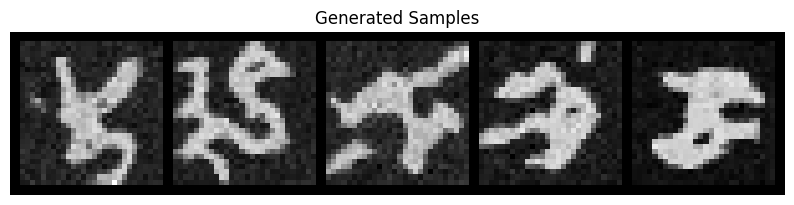

  Step 600/750, Loss: 0.0574
  Step 700/750, Loss: 0.0571

Training - Epoch 1 average loss: 0.0681
Running validation...
Validation - Epoch 1 average loss: 0.0656
Learning rate: 0.001000

Generating samples for visual progress check...


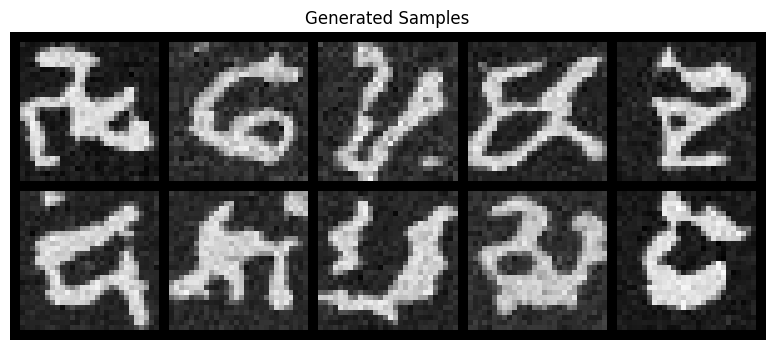

Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0656)


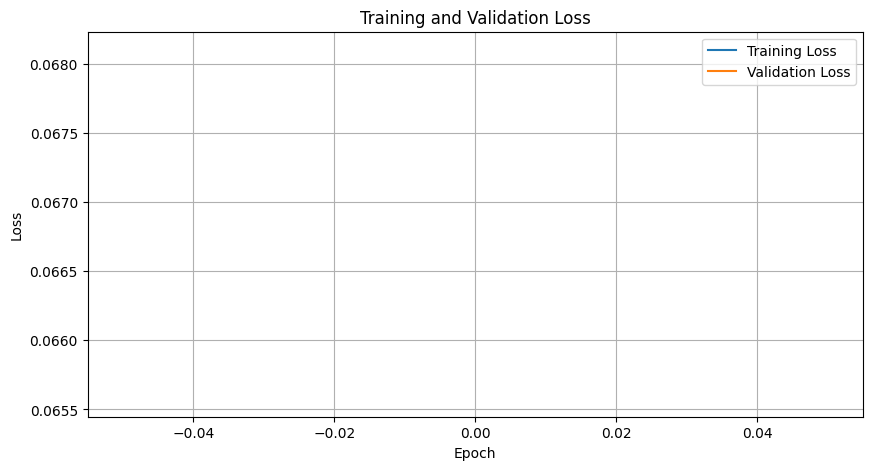


Epoch 2/30
--------------------
  Step 0/750, Loss: 0.0615
  Step 100/750, Loss: 0.0657
  Step 200/750, Loss: 0.0678
  Step 300/750, Loss: 0.0552
  Step 400/750, Loss: 0.0634
  Step 500/750, Loss: 0.0636
  Generating samples...


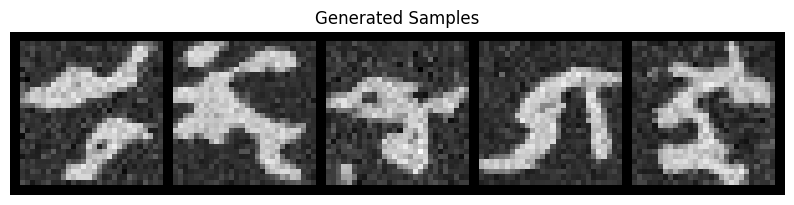

  Step 600/750, Loss: 0.0594
  Step 700/750, Loss: 0.0588

Training - Epoch 2 average loss: 0.0648
Running validation...
Validation - Epoch 2 average loss: 0.0631
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0631)

Epoch 3/30
--------------------
  Step 0/750, Loss: 0.0765
  Step 100/750, Loss: 0.0575
  Step 200/750, Loss: 0.0608
  Step 300/750, Loss: 0.0674
  Step 400/750, Loss: 0.0628
  Step 500/750, Loss: 0.0676
  Generating samples...


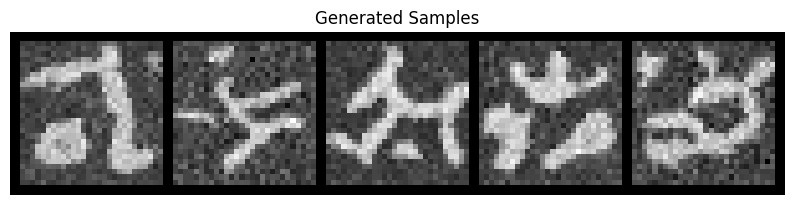

  Step 600/750, Loss: 0.0608
  Step 700/750, Loss: 0.0606

Training - Epoch 3 average loss: 0.0627
Running validation...
Validation - Epoch 3 average loss: 0.0613
Learning rate: 0.001000

Generating samples for visual progress check...


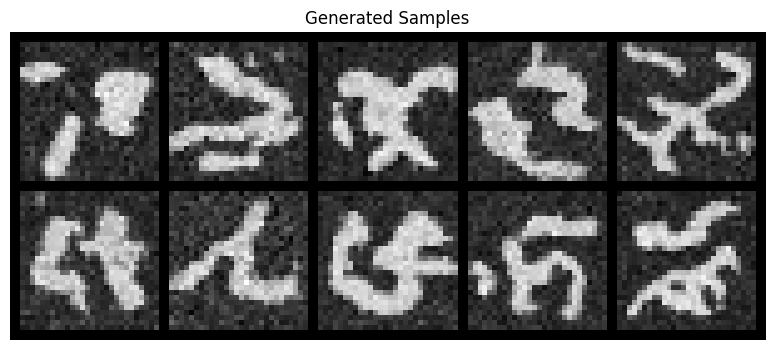

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0613)

Epoch 4/30
--------------------
  Step 0/750, Loss: 0.0578
  Step 100/750, Loss: 0.0595
  Step 200/750, Loss: 0.0565
  Step 300/750, Loss: 0.0552
  Step 400/750, Loss: 0.0577
  Step 500/750, Loss: 0.0616
  Generating samples...


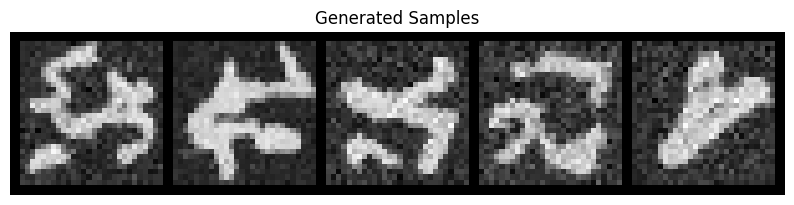

  Step 600/750, Loss: 0.0626
  Step 700/750, Loss: 0.0639

Training - Epoch 4 average loss: 0.0609
Running validation...
Validation - Epoch 4 average loss: 0.0591
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0591)

Epoch 5/30
--------------------
  Step 0/750, Loss: 0.0625
  Step 100/750, Loss: 0.0600
  Step 200/750, Loss: 0.0586
  Step 300/750, Loss: 0.0655
  Step 400/750, Loss: 0.0544
  Step 500/750, Loss: 0.0578
  Generating samples...


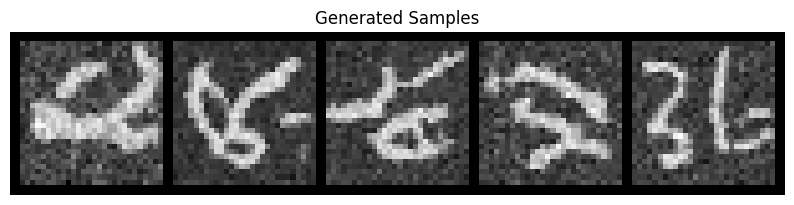

  Step 600/750, Loss: 0.0612
  Step 700/750, Loss: 0.0613

Training - Epoch 5 average loss: 0.0603
Running validation...
Validation - Epoch 5 average loss: 0.0591
Learning rate: 0.001000

Generating samples for visual progress check...


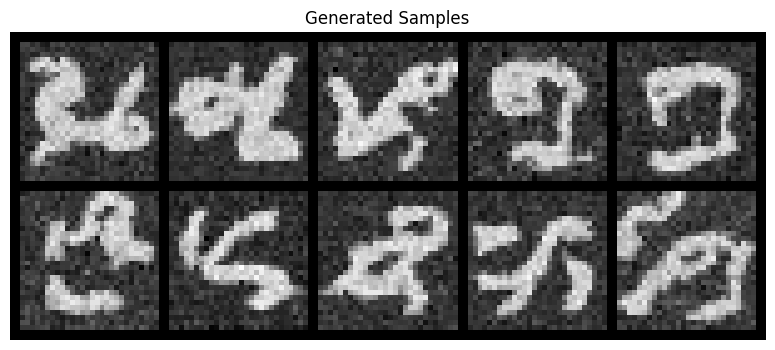

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0591)

Epoch 6/30
--------------------
  Step 0/750, Loss: 0.0589
  Step 100/750, Loss: 0.0600
  Step 200/750, Loss: 0.0580
  Step 300/750, Loss: 0.0671
  Step 400/750, Loss: 0.0636
  Step 500/750, Loss: 0.0527
  Generating samples...


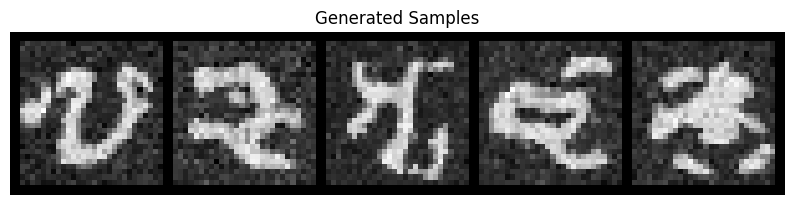

  Step 600/750, Loss: 0.0614
  Step 700/750, Loss: 0.0637

Training - Epoch 6 average loss: 0.0595
Running validation...
Validation - Epoch 6 average loss: 0.0602
Learning rate: 0.001000
No improvement for 1/10 epochs


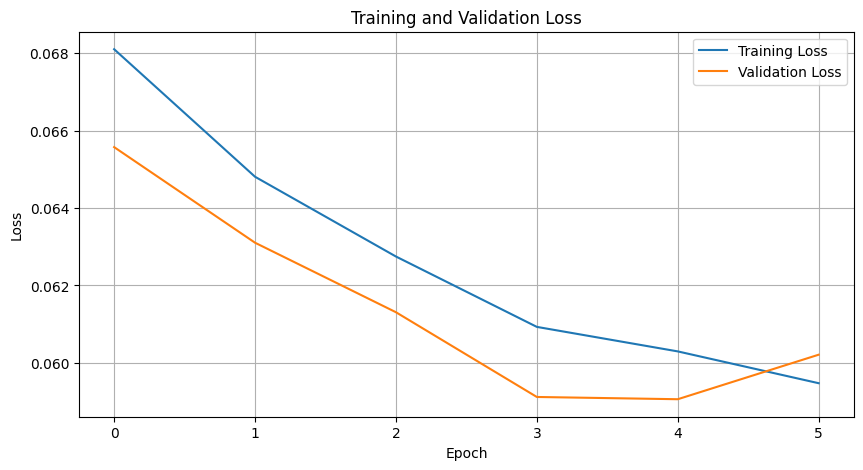


Epoch 7/30
--------------------
  Step 0/750, Loss: 0.0626
  Step 100/750, Loss: 0.0601
  Step 200/750, Loss: 0.0649
  Step 300/750, Loss: 0.0629
  Step 400/750, Loss: 0.0549
  Step 500/750, Loss: 0.0536
  Generating samples...


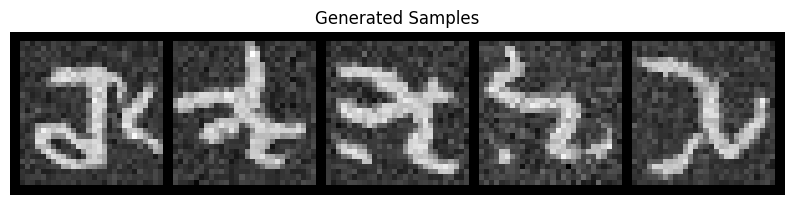

  Step 600/750, Loss: 0.0560
  Step 700/750, Loss: 0.0569

Training - Epoch 7 average loss: 0.0593
Running validation...
Validation - Epoch 7 average loss: 0.0579
Learning rate: 0.001000

Generating samples for visual progress check...


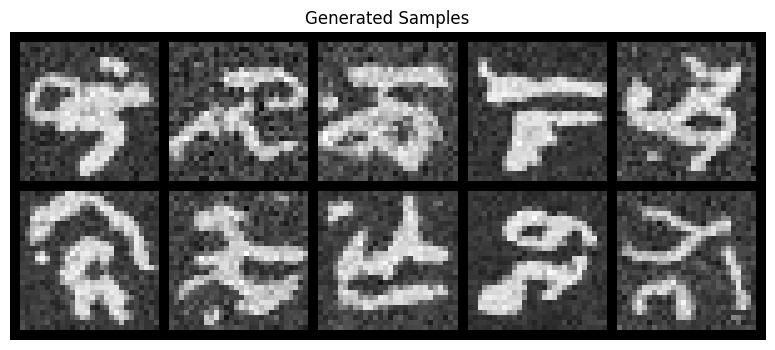

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0579)

Epoch 8/30
--------------------
  Step 0/750, Loss: 0.0566
  Step 100/750, Loss: 0.0525
  Step 200/750, Loss: 0.0528
  Step 300/750, Loss: 0.0572
  Step 400/750, Loss: 0.0519
  Step 500/750, Loss: 0.0564
  Generating samples...


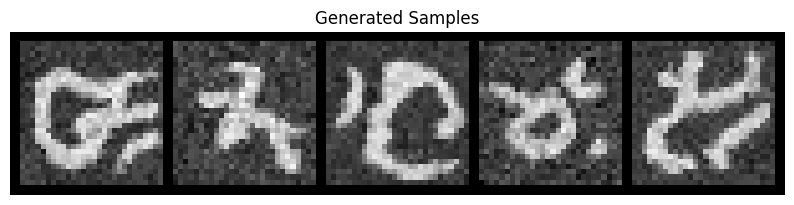

  Step 600/750, Loss: 0.0604
  Step 700/750, Loss: 0.0556

Training - Epoch 8 average loss: 0.0584
Running validation...
Validation - Epoch 8 average loss: 0.0577
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0577)

Epoch 9/30
--------------------
  Step 0/750, Loss: 0.0584
  Step 100/750, Loss: 0.0618
  Step 200/750, Loss: 0.0614
  Step 300/750, Loss: 0.0681
  Step 400/750, Loss: 0.0640
  Step 500/750, Loss: 0.0516
  Generating samples...


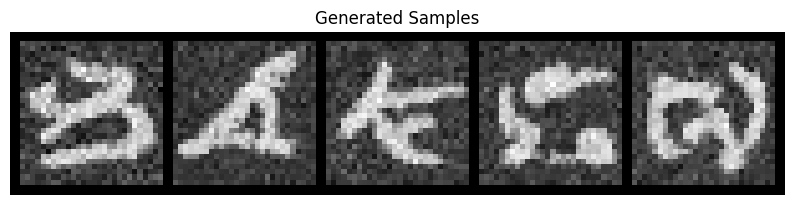

  Step 600/750, Loss: 0.0483
  Step 700/750, Loss: 0.0596

Training - Epoch 9 average loss: 0.0583
Running validation...
Validation - Epoch 9 average loss: 0.0589
Learning rate: 0.001000

Generating samples for visual progress check...


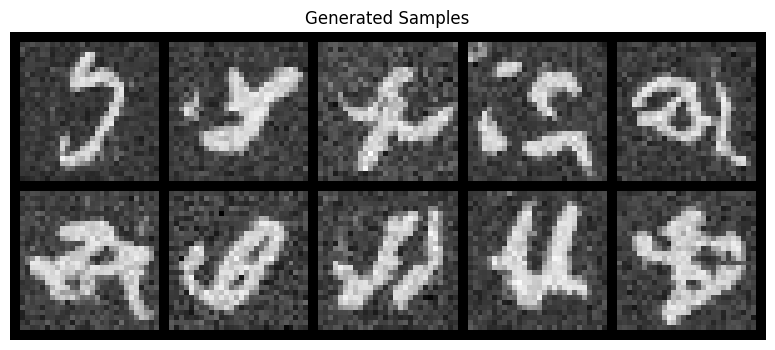

No improvement for 1/10 epochs

Epoch 10/30
--------------------
  Step 0/750, Loss: 0.0641
  Step 100/750, Loss: 0.0539
  Step 200/750, Loss: 0.0503
  Step 300/750, Loss: 0.0597
  Step 400/750, Loss: 0.0636
  Step 500/750, Loss: 0.0494
  Generating samples...


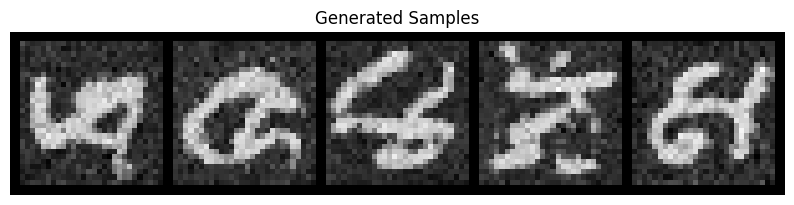

  Step 600/750, Loss: 0.0580
  Step 700/750, Loss: 0.0577

Training - Epoch 10 average loss: 0.0581
Running validation...
Validation - Epoch 10 average loss: 0.0576
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0576)

Epoch 11/30
--------------------
  Step 0/750, Loss: 0.0569
  Step 100/750, Loss: 0.0670
  Step 200/750, Loss: 0.0569
  Step 300/750, Loss: 0.0651
  Step 400/750, Loss: 0.0578
  Step 500/750, Loss: 0.0656
  Generating samples...


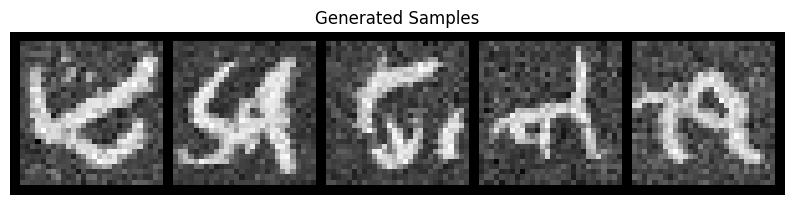

  Step 600/750, Loss: 0.0516
  Step 700/750, Loss: 0.0595

Training - Epoch 11 average loss: 0.0579
Running validation...
Validation - Epoch 11 average loss: 0.0582
Learning rate: 0.001000

Generating samples for visual progress check...


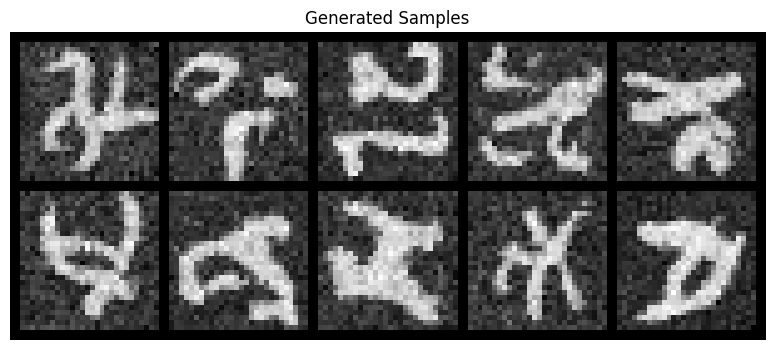

No improvement for 1/10 epochs


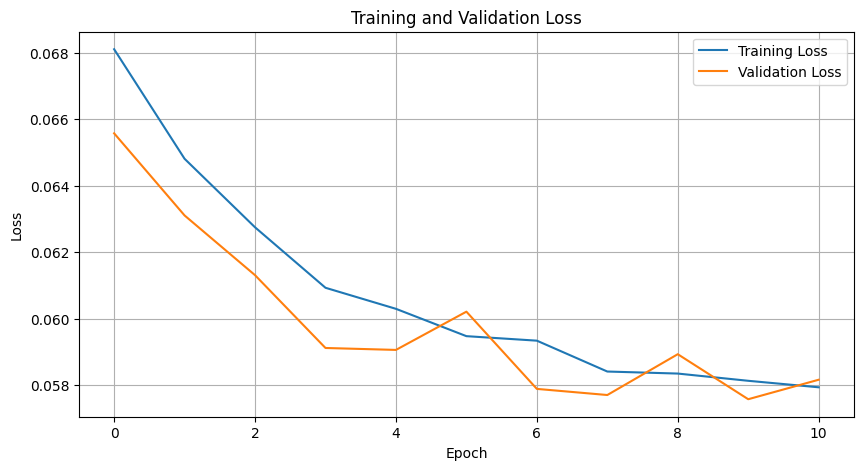


Epoch 12/30
--------------------
  Step 0/750, Loss: 0.0515
  Step 100/750, Loss: 0.0576
  Step 200/750, Loss: 0.0524
  Step 300/750, Loss: 0.0595
  Step 400/750, Loss: 0.0556
  Step 500/750, Loss: 0.0594
  Generating samples...


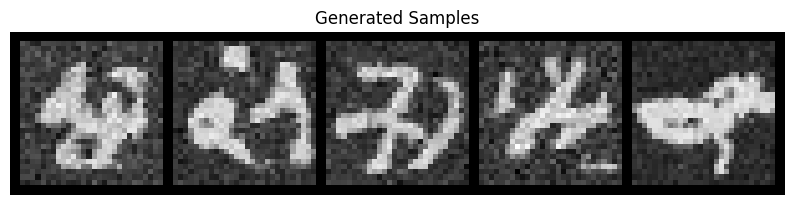

  Step 600/750, Loss: 0.0641
  Step 700/750, Loss: 0.0566

Training - Epoch 12 average loss: 0.0579
Running validation...
Validation - Epoch 12 average loss: 0.0572
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0572)

Epoch 13/30
--------------------
  Step 0/750, Loss: 0.0629
  Step 100/750, Loss: 0.0545
  Step 200/750, Loss: 0.0502
  Step 300/750, Loss: 0.0558
  Step 400/750, Loss: 0.0564
  Step 500/750, Loss: 0.0530
  Generating samples...


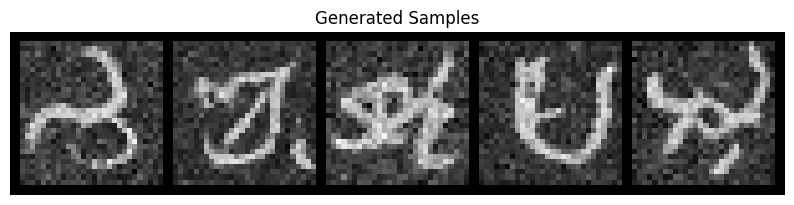

  Step 600/750, Loss: 0.0576
  Step 700/750, Loss: 0.0536

Training - Epoch 13 average loss: 0.0575
Running validation...
Validation - Epoch 13 average loss: 0.0577
Learning rate: 0.001000

Generating samples for visual progress check...


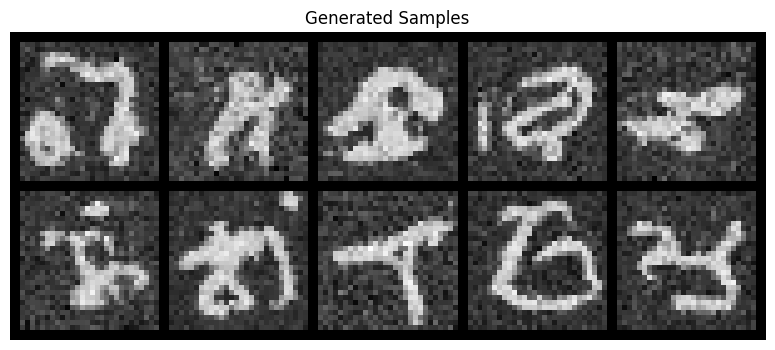

No improvement for 1/10 epochs

Epoch 14/30
--------------------
  Step 0/750, Loss: 0.0571
  Step 100/750, Loss: 0.0574
  Step 200/750, Loss: 0.0560
  Step 300/750, Loss: 0.0581
  Step 400/750, Loss: 0.0631
  Step 500/750, Loss: 0.0572
  Generating samples...


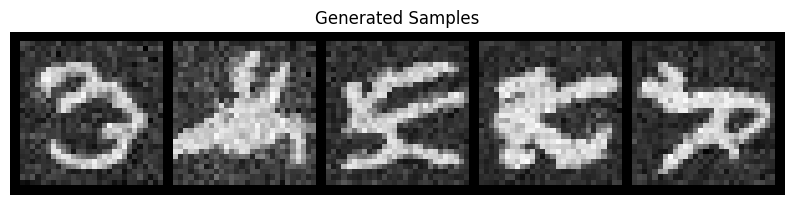

  Step 600/750, Loss: 0.0581
  Step 700/750, Loss: 0.0522

Training - Epoch 14 average loss: 0.0575
Running validation...
Validation - Epoch 14 average loss: 0.0566
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0566)

Epoch 15/30
--------------------
  Step 0/750, Loss: 0.0638
  Step 100/750, Loss: 0.0584
  Step 200/750, Loss: 0.0575
  Step 300/750, Loss: 0.0549
  Step 400/750, Loss: 0.0497
  Step 500/750, Loss: 0.0594
  Generating samples...


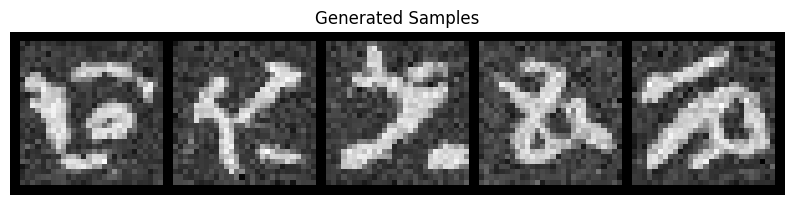

  Step 600/750, Loss: 0.0552
  Step 700/750, Loss: 0.0586

Training - Epoch 15 average loss: 0.0572
Running validation...
Validation - Epoch 15 average loss: 0.0559
Learning rate: 0.001000

Generating samples for visual progress check...


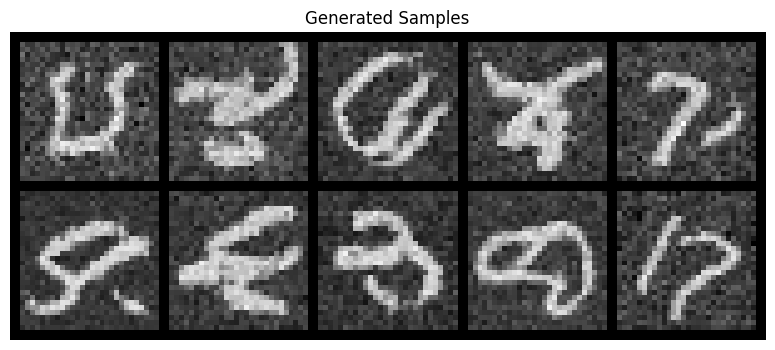

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0559)

Epoch 16/30
--------------------
  Step 0/750, Loss: 0.0565
  Step 100/750, Loss: 0.0524
  Step 200/750, Loss: 0.0523
  Step 300/750, Loss: 0.0580
  Step 400/750, Loss: 0.0576
  Step 500/750, Loss: 0.0621
  Generating samples...


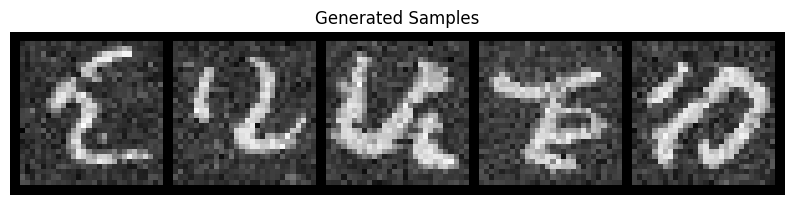

  Step 600/750, Loss: 0.0581
  Step 700/750, Loss: 0.0542

Training - Epoch 16 average loss: 0.0567
Running validation...
Validation - Epoch 16 average loss: 0.0559
Learning rate: 0.001000
No improvement for 1/10 epochs


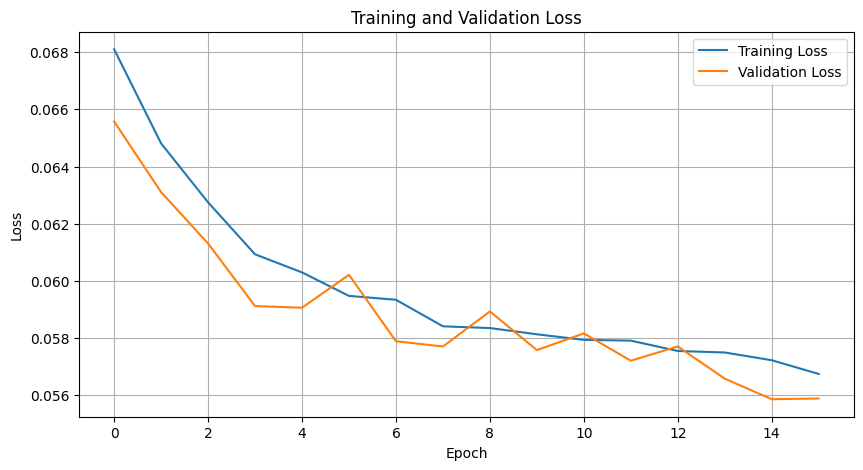


Epoch 17/30
--------------------
  Step 0/750, Loss: 0.0544
  Step 100/750, Loss: 0.0619
  Step 200/750, Loss: 0.0577
  Step 300/750, Loss: 0.0538
  Step 400/750, Loss: 0.0518
  Step 500/750, Loss: 0.0524
  Generating samples...


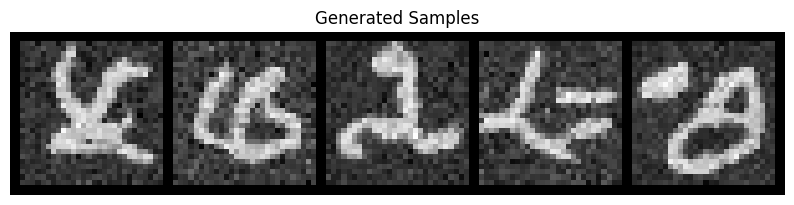

  Step 600/750, Loss: 0.0555
  Step 700/750, Loss: 0.0506

Training - Epoch 17 average loss: 0.0567
Running validation...
Validation - Epoch 17 average loss: 0.0560
Learning rate: 0.001000

Generating samples for visual progress check...


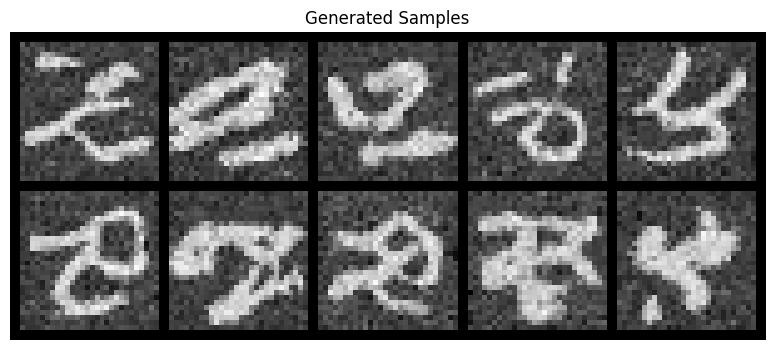

No improvement for 2/10 epochs

Epoch 18/30
--------------------
  Step 0/750, Loss: 0.0625
  Step 100/750, Loss: 0.0515
  Step 200/750, Loss: 0.0508
  Step 300/750, Loss: 0.0611
  Step 400/750, Loss: 0.0531
  Step 500/750, Loss: 0.0546
  Generating samples...


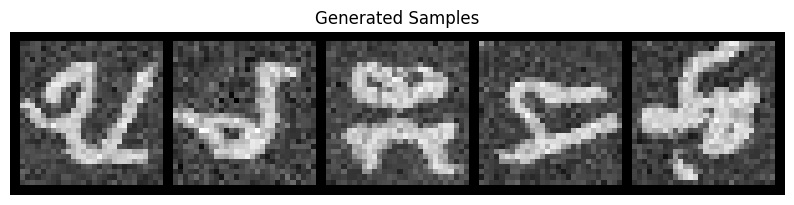

  Step 600/750, Loss: 0.0572
  Step 700/750, Loss: 0.0631

Training - Epoch 18 average loss: 0.0564
Running validation...
Validation - Epoch 18 average loss: 0.0564
Learning rate: 0.001000
No improvement for 3/10 epochs

Epoch 19/30
--------------------
  Step 0/750, Loss: 0.0582
  Step 100/750, Loss: 0.0549
  Step 200/750, Loss: 0.0540
  Step 300/750, Loss: 0.0536
  Step 400/750, Loss: 0.0575
  Step 500/750, Loss: 0.0612
  Generating samples...


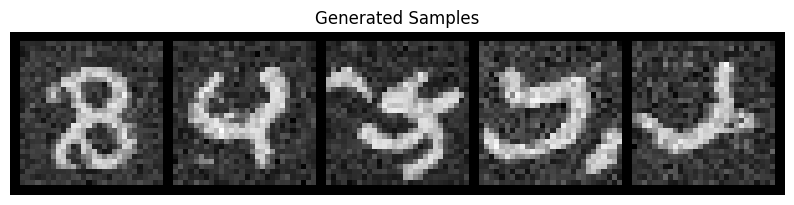

  Step 600/750, Loss: 0.0526
  Step 700/750, Loss: 0.0632

Training - Epoch 19 average loss: 0.0566
Running validation...
Validation - Epoch 19 average loss: 0.0560
Learning rate: 0.001000

Generating samples for visual progress check...


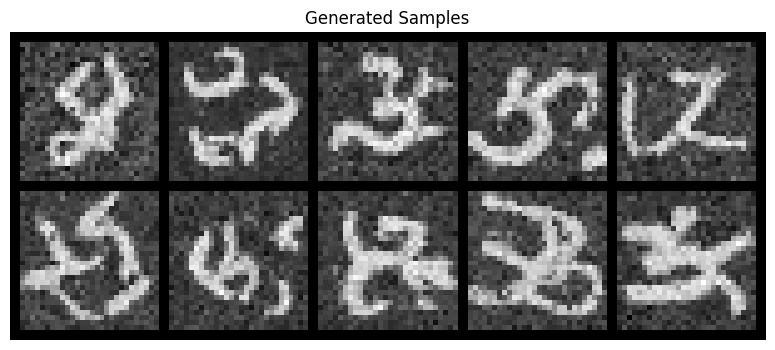

No improvement for 4/10 epochs

Epoch 20/30
--------------------
  Step 0/750, Loss: 0.0534
  Step 100/750, Loss: 0.0543
  Step 200/750, Loss: 0.0559
  Step 300/750, Loss: 0.0653
  Step 400/750, Loss: 0.0622
  Step 500/750, Loss: 0.0607
  Generating samples...


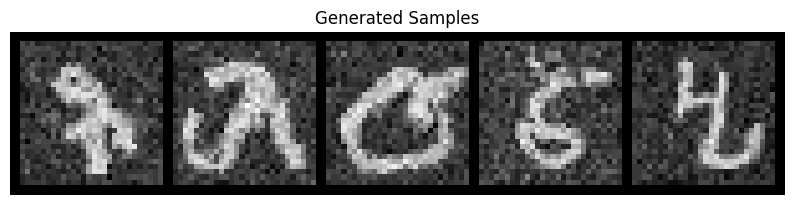

  Step 600/750, Loss: 0.0533
  Step 700/750, Loss: 0.0628

Training - Epoch 20 average loss: 0.0567
Running validation...
Validation - Epoch 20 average loss: 0.0561
Learning rate: 0.001000
No improvement for 5/10 epochs

Epoch 21/30
--------------------
  Step 0/750, Loss: 0.0562
  Step 100/750, Loss: 0.0593
  Step 200/750, Loss: 0.0559
  Step 300/750, Loss: 0.0514
  Step 400/750, Loss: 0.0629
  Step 500/750, Loss: 0.0487
  Generating samples...


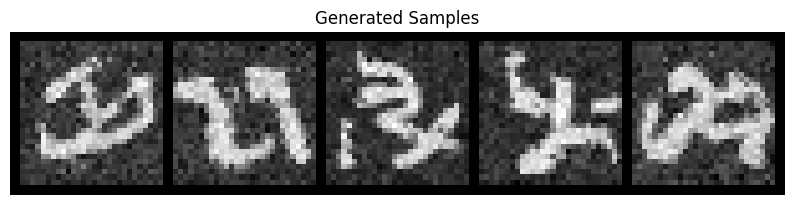

  Step 600/750, Loss: 0.0610
  Step 700/750, Loss: 0.0620

Training - Epoch 21 average loss: 0.0564
Running validation...
Validation - Epoch 21 average loss: 0.0555
Learning rate: 0.001000

Generating samples for visual progress check...


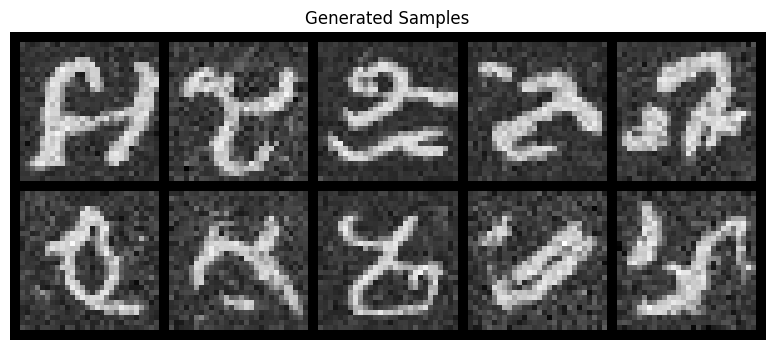

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0555)


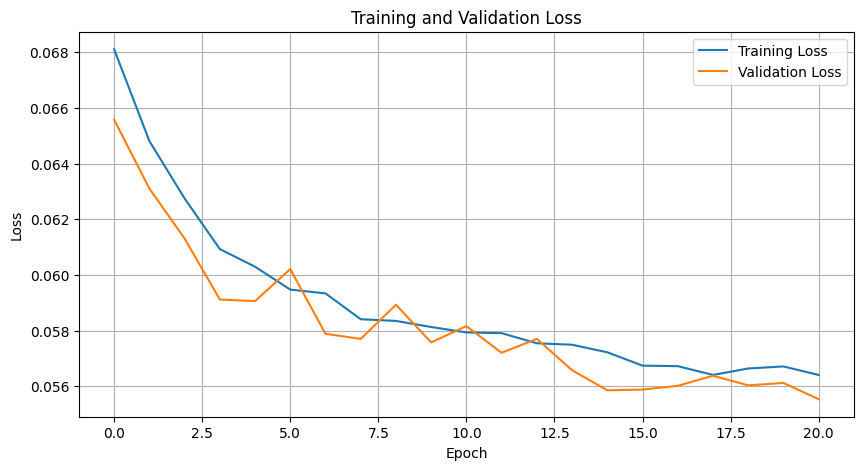


Epoch 22/30
--------------------
  Step 0/750, Loss: 0.0475
  Step 100/750, Loss: 0.0546
  Step 200/750, Loss: 0.0563
  Step 300/750, Loss: 0.0565
  Step 400/750, Loss: 0.0579
  Step 500/750, Loss: 0.0534
  Generating samples...


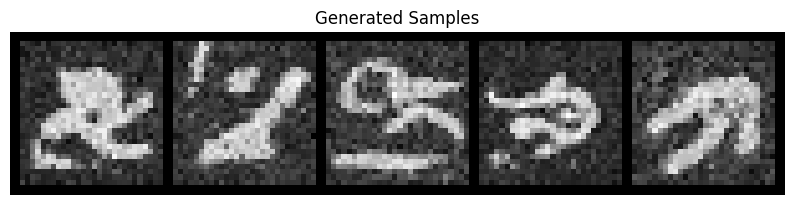

  Step 600/750, Loss: 0.0547
  Step 700/750, Loss: 0.0466

Training - Epoch 22 average loss: 0.0564
Running validation...
Validation - Epoch 22 average loss: 0.0555
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0555)

Epoch 23/30
--------------------
  Step 0/750, Loss: 0.0537
  Step 100/750, Loss: 0.0618
  Step 200/750, Loss: 0.0521
  Step 300/750, Loss: 0.0541
  Step 400/750, Loss: 0.0535
  Step 500/750, Loss: 0.0585
  Generating samples...


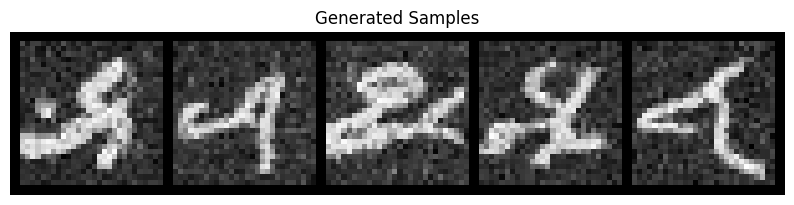

  Step 600/750, Loss: 0.0572
  Step 700/750, Loss: 0.0611

Training - Epoch 23 average loss: 0.0564
Running validation...
Validation - Epoch 23 average loss: 0.0563
Learning rate: 0.001000

Generating samples for visual progress check...


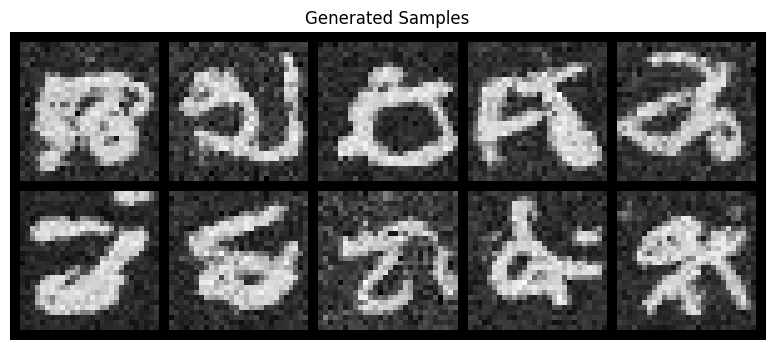

No improvement for 1/10 epochs

Epoch 24/30
--------------------
  Step 0/750, Loss: 0.0551
  Step 100/750, Loss: 0.0543
  Step 200/750, Loss: 0.0550
  Step 300/750, Loss: 0.0534
  Step 400/750, Loss: 0.0579
  Step 500/750, Loss: 0.0462
  Generating samples...


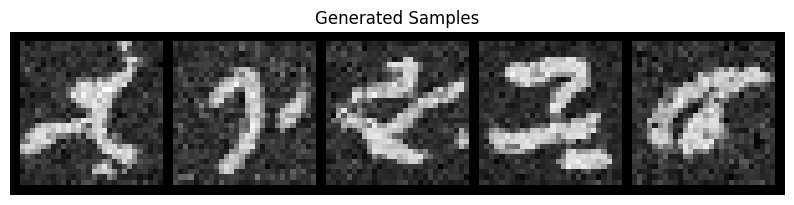

  Step 600/750, Loss: 0.0540
  Step 700/750, Loss: 0.0618

Training - Epoch 24 average loss: 0.0562
Running validation...
Validation - Epoch 24 average loss: 0.0562
Learning rate: 0.001000
No improvement for 2/10 epochs

Epoch 25/30
--------------------
  Step 0/750, Loss: 0.0524
  Step 100/750, Loss: 0.0545
  Step 200/750, Loss: 0.0508
  Step 300/750, Loss: 0.0481
  Step 400/750, Loss: 0.0527
  Step 500/750, Loss: 0.0569
  Generating samples...


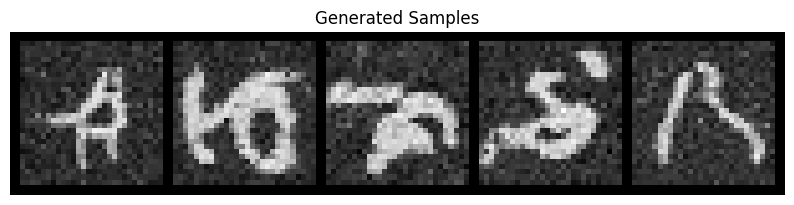

  Step 600/750, Loss: 0.0620
  Step 700/750, Loss: 0.0593

Training - Epoch 25 average loss: 0.0560
Running validation...
Validation - Epoch 25 average loss: 0.0553
Learning rate: 0.001000

Generating samples for visual progress check...


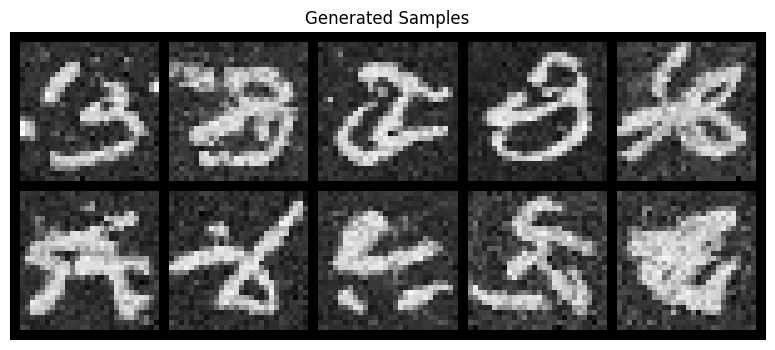

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0553)

Epoch 26/30
--------------------
  Step 0/750, Loss: 0.0471
  Step 100/750, Loss: 0.0617
  Step 200/750, Loss: 0.0605
  Step 300/750, Loss: 0.0541
  Step 400/750, Loss: 0.0554
  Step 500/750, Loss: 0.0547
  Generating samples...


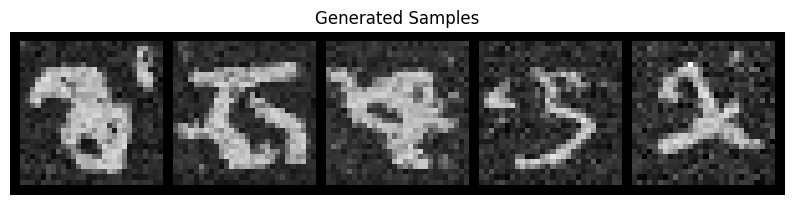

  Step 600/750, Loss: 0.0603
  Step 700/750, Loss: 0.0630

Training - Epoch 26 average loss: 0.0561
Running validation...
Validation - Epoch 26 average loss: 0.0562
Learning rate: 0.001000
No improvement for 1/10 epochs


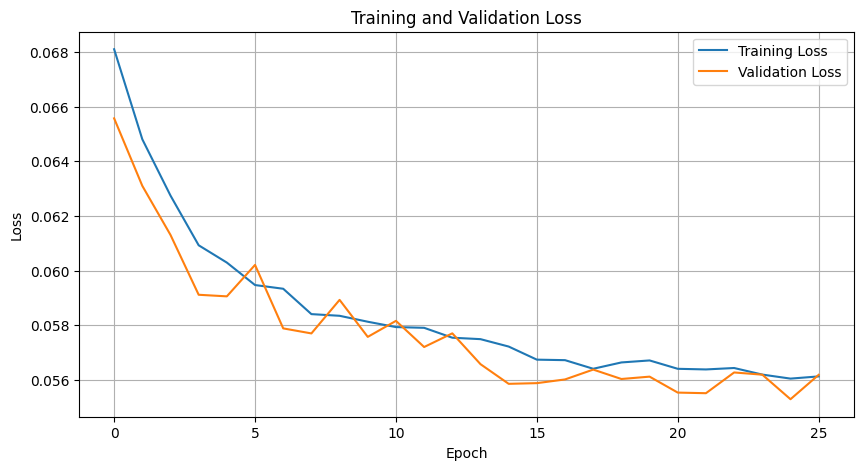


Epoch 27/30
--------------------
  Step 0/750, Loss: 0.0564
  Step 100/750, Loss: 0.0535
  Step 200/750, Loss: 0.0579
  Step 300/750, Loss: 0.0548
  Step 400/750, Loss: 0.0571
  Step 500/750, Loss: 0.0563
  Generating samples...


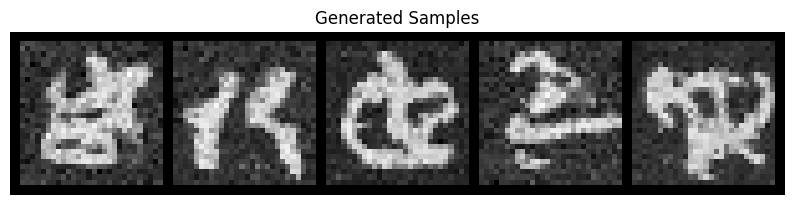

  Step 600/750, Loss: 0.0595
  Step 700/750, Loss: 0.0545

Training - Epoch 27 average loss: 0.0559
Running validation...
Validation - Epoch 27 average loss: 0.0554
Learning rate: 0.001000

Generating samples for visual progress check...


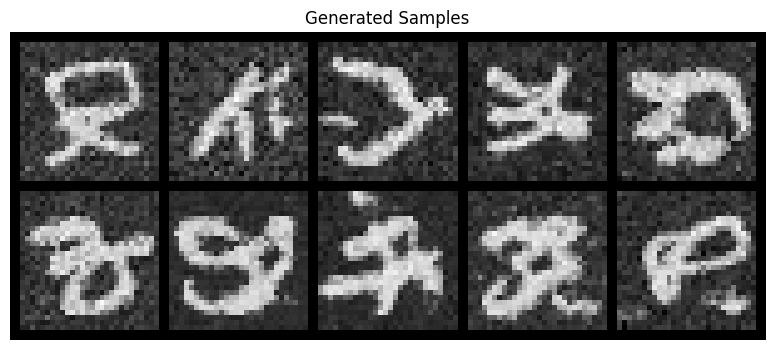

No improvement for 2/10 epochs

Epoch 28/30
--------------------
  Step 0/750, Loss: 0.0528
  Step 100/750, Loss: 0.0628
  Step 200/750, Loss: 0.0585
  Step 300/750, Loss: 0.0635
  Step 400/750, Loss: 0.0511
  Step 500/750, Loss: 0.0532
  Generating samples...


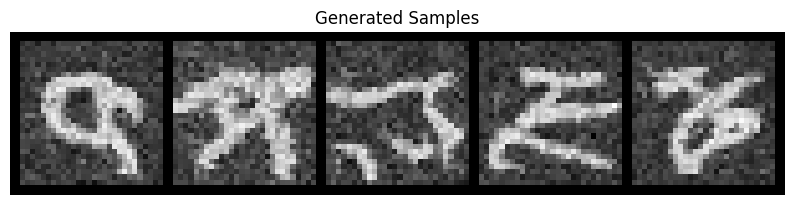

  Step 600/750, Loss: 0.0598
  Step 700/750, Loss: 0.0547

Training - Epoch 28 average loss: 0.0557
Running validation...
Validation - Epoch 28 average loss: 0.0554
Learning rate: 0.001000
No improvement for 3/10 epochs

Epoch 29/30
--------------------
  Step 0/750, Loss: 0.0541
  Step 100/750, Loss: 0.0588
  Step 200/750, Loss: 0.0559
  Step 300/750, Loss: 0.0651
  Step 400/750, Loss: 0.0571
  Step 500/750, Loss: 0.0547
  Generating samples...


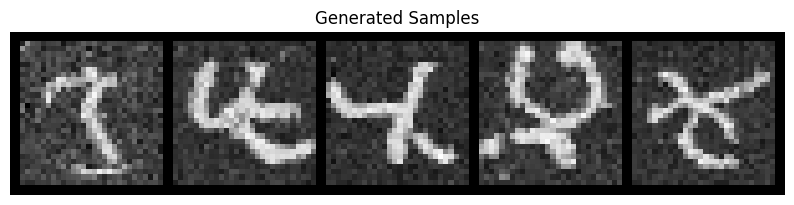

  Step 600/750, Loss: 0.0579
  Step 700/750, Loss: 0.0596

Training - Epoch 29 average loss: 0.0558
Running validation...
Validation - Epoch 29 average loss: 0.0552
Learning rate: 0.001000

Generating samples for visual progress check...


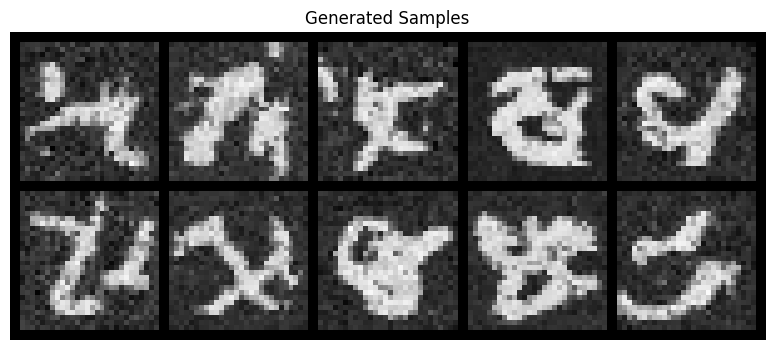

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0552)

Epoch 30/30
--------------------
  Step 0/750, Loss: 0.0595
  Step 100/750, Loss: 0.0479
  Step 200/750, Loss: 0.0539
  Step 300/750, Loss: 0.0533
  Step 400/750, Loss: 0.0532
  Step 500/750, Loss: 0.0555
  Generating samples...


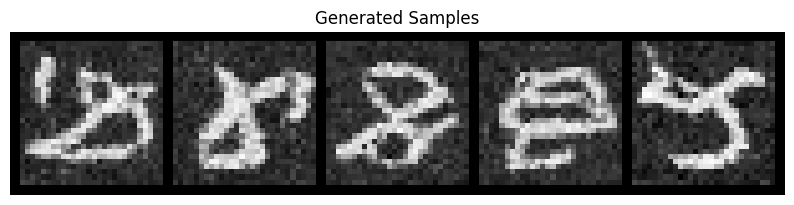

  Step 600/750, Loss: 0.0551
  Step 700/750, Loss: 0.0606

Training - Epoch 30 average loss: 0.0557
Running validation...
Validation - Epoch 30 average loss: 0.0555
Learning rate: 0.001000

Generating samples for visual progress check...


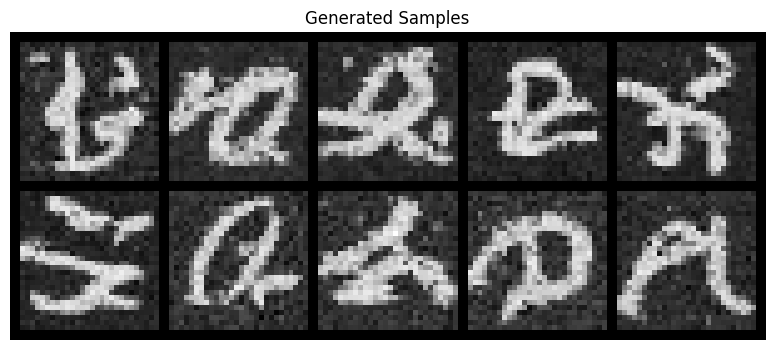

No improvement for 1/10 epochs


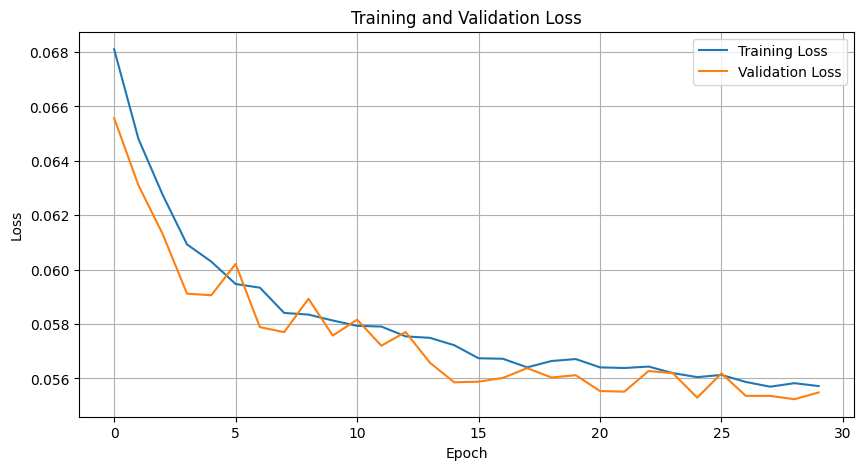


TRAINING COMPLETE
Best validation loss: 0.0552
Generating final samples...


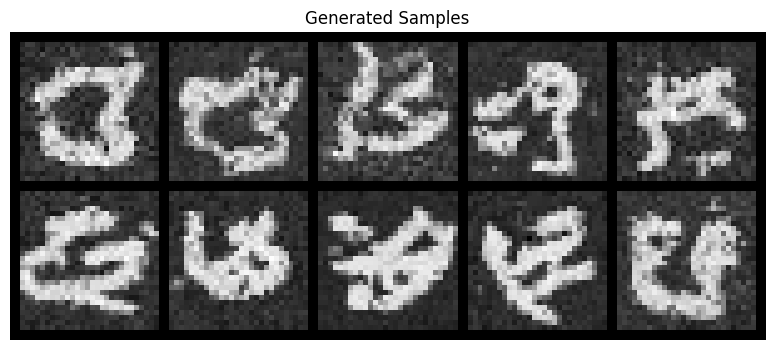

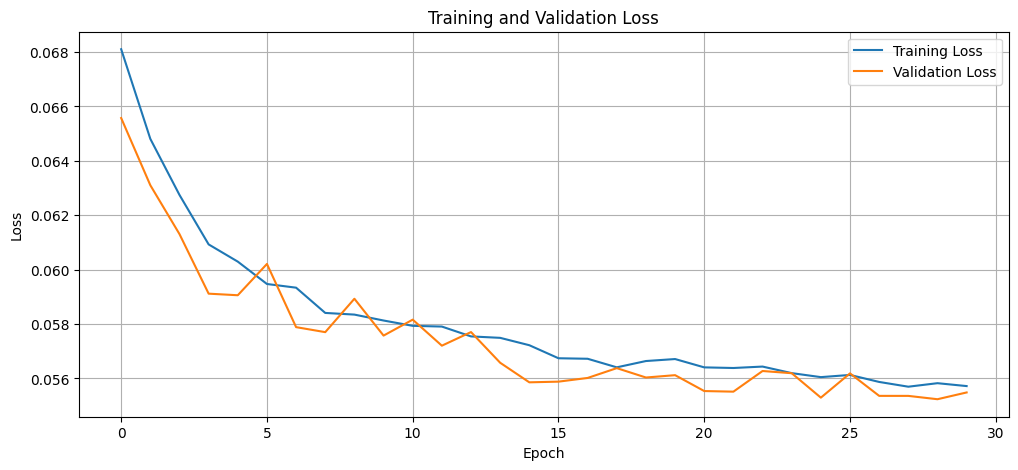

In [ ]:
# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)
model.train()

# Wrap the training loop in a try-except block for better error handling:
# Your code for the training loop
# Hint: Use a try-except block for better error handling
# Process each epoch and each batch, with validation after each epoch

# Enter your code here:

try:
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_dataloader):  # Fixed: dataloader → train_dataloader
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    generate_samples(model, n_samples=5)

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_dataloader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            generate_samples(model, n_samples=10)

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # Use safe_save_model instead of just saving state_dict
            safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss)
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()


except Exception as e:
    print(f"An error occurred during training: {e}")
    import traceback
    traceback.print_exc()

# Final wrap-up
print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)
print(f"Best validation loss: {best_loss:.4f}")

# Generate final samples
print("Generating final samples...")
generate_samples(model, n_samples=10)

# Display final loss curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Clean up memory
torch.cuda.empty_cache()

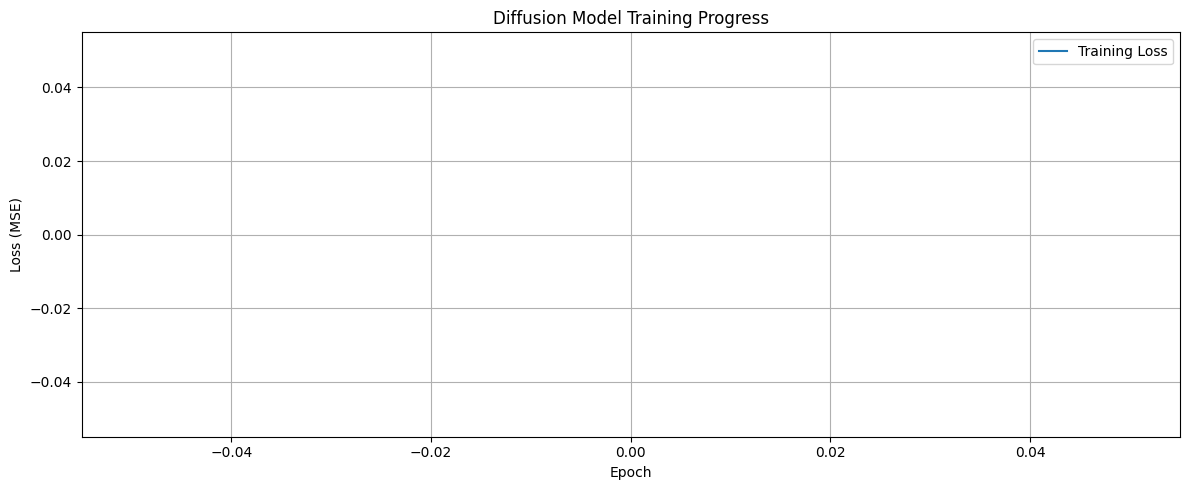


Training Statistics:
------------------------------


In [ ]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points
if train_losses: # Check if list is not empty
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}',
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses)*1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Add validation min point if available
if val_losses: # Check if list is not empty
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}',
                xy=(min_val_idx, min(val_losses)),
                xytext=(min_val_idx, min(val_losses)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
# Only set ylim if there is data to plot
if train_losses or val_losses:
    min_loss = min(min(train_losses) if train_losses else float('inf'),
                   min(val_losses) if val_losses else float('inf'))
    plt.ylim(bottom=max(0, min_loss * 0.9))


plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss
#    (which can indicate overfitting when the ratio increases)

## Step 6: Generating New Images

Now that our model is trained, let's generate some new images! We can:
1. Generate specific numbers
2. Generate multiple versions of each number
3. See how the generation process works step by step

Generating 4 versions of number 0...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 1...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 2...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 3...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 4...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 

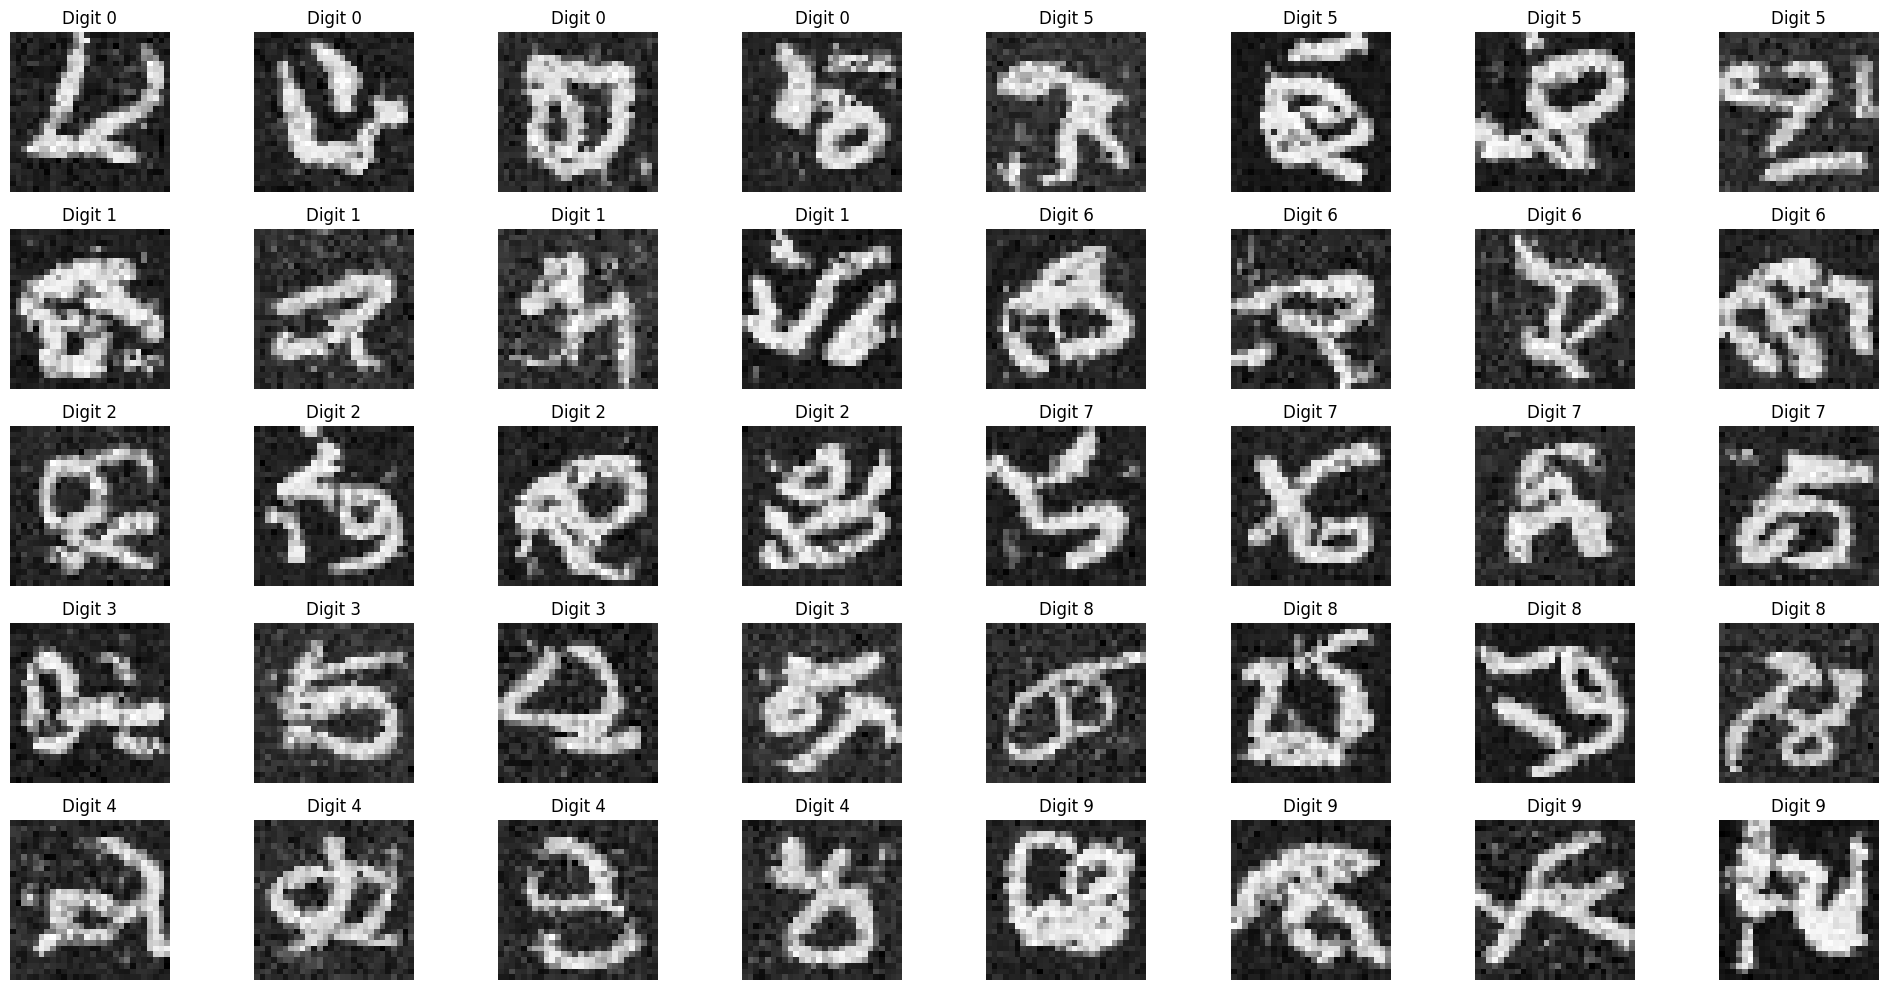


STUDENT ACTIVITY: Generating numbers with different noise seeds


In [ ]:
def generate_number(model, number, n_samples=4):
    """
    Generate multiple versions of a specific number using the diffusion model.

    Args:
        model (nn.Module): The trained diffusion model
        number (int): The digit to generate (0-9)
        n_samples (int): Number of variations to generate

    Returns:
        torch.Tensor: Generated images of shape [n_samples, IMG_CH, IMG_SIZE, IMG_SIZE]
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need for gradients during generation
        # Start with random noise
        samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up the number we want to generate
        c = torch.full((n_samples,), number).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        # Correctly sized conditioning mask for broadcasting with spatial dimensions
        # This should have shape [n_samples, 1, 1, 1]
        c_mask = torch.ones(n_samples, 1, 1, 1).to(device)


        # Display progress information
        print(f"Generating {n_samples} versions of number {number}...")

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((n_samples,), t).to(device)
            samples = remove_noise(samples, t_batch, model, c_one_hot, c_mask)

            # Optional: Display occasional progress updates
            if t % (n_steps // 5) == 0:
                print(f"  Denoising step {n_steps-1-t}/{n_steps-1} completed")

        return samples

# Generate 4 versions of each number
plt.figure(figsize=(20, 10))
for i in range(10):
    # Generate samples for current digit
    samples = generate_number(model, i, n_samples=4)

    # Display each sample
    for j in range(4):
        # Use 2 rows, 10 digits per row, 4 samples per digit
        # i//5 determines the row (0 or 1)
        # i%5 determines the position in the row (0-4)
        # j is the sample index within each digit (0-3)
        plt.subplot(5, 8, (i%5)*8 + (i//5)*4 + j + 1)

        # Display the image correctly based on channel configuration
        if IMG_CH == 1:  # Grayscale
            plt.imshow(samples[j][0].cpu(), cmap='gray')
        else:  # Color image
            img = samples[j].permute(1, 2, 0).cpu()
            # Rescale from [-1, 1] to [0, 1] if needed
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)

        plt.title(f'Digit {i}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# STUDENT ACTIVITY: Try generating the same digit with different noise seeds
# This shows the variety of styles the model can produce
print("\nSTUDENT ACTIVITY: Generating numbers with different noise seeds")

# Helper function to generate with seed
def generate_with_seed(number, seed_value=42, n_samples=10):
    torch.manual_seed(seed_value)
    return generate_number(model, number, n_samples)

# Pick a image and show many variations
# Hint select a image e.g. dog  # Change this to any other in the dataset of subset you chose
# Hint 2 use variations = generate_with_seed
# Hint 3 use plt.figure and plt.imshow to display the variations

# Enter your code here:

## Step 7: Watching the Generation Process

Let's see how our model turns random noise into clear images, step by step. This helps us understand how the diffusion process works!


Generating number 0:


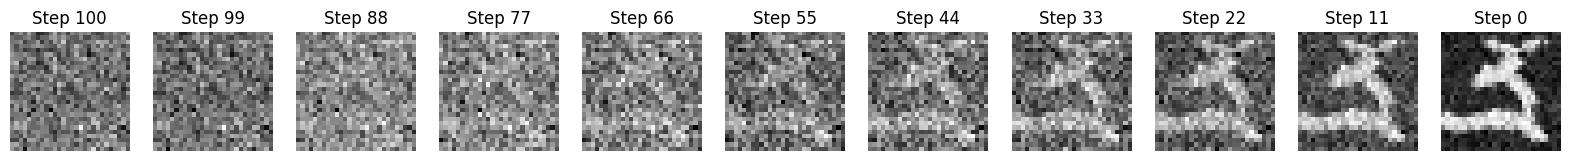


Generating number 3:


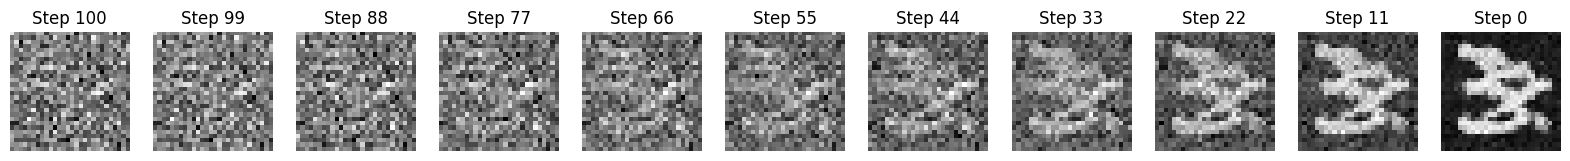


Generating number 7:


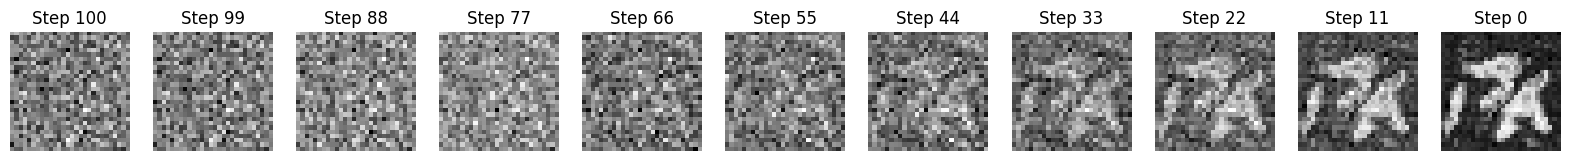

In [ ]:
def visualize_generation_steps(model, number, n_preview_steps=10):
    """
    Show how an image evolves from noise to a clear number
    """
    model.eval()
    with torch.no_grad():
        # Start with random noise
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up which number to generate
        c = torch.tensor([number]).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        # Correct the c_mask shape for broadcasting
        c_mask = torch.ones(c_one_hot.shape[0], 1, 1, 1).to(device)

        # Calculate which steps to show
        steps_to_show = torch.linspace(n_steps-1, 0, n_preview_steps).long()

        # Store images for visualization
        images = []
        images.append(x[0].cpu())

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((1,), t).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            if t in steps_to_show:
                images.append(x[0].cpu())

        # Show the progression
        plt.figure(figsize=(20, 3))
        for i, img in enumerate(images):
            plt.subplot(1, len(images), i+1)
            if IMG_CH == 1:
                plt.imshow(img[0], cmap='gray')
            else:
                img = img.permute(1, 2, 0)
                if img.min() < 0:
                    img = (img + 1) / 2
                plt.imshow(img)
            step = n_steps if i == 0 else steps_to_show[i-1]
            plt.title(f'Step {step}')
            plt.axis('off')
        plt.show()

# Show generation process for a few numbers
for number in [0, 3, 7]:
    print(f"\nGenerating number {number}:")
    visualize_generation_steps(model, number)

## Step 8: Adding CLIP Evaluation

[CLIP](https://openai.com/research/clip) is a powerful AI model that can understand both images and text. We'll use it to:
1. Evaluate how realistic our generated images are
2. Score how well they match their intended numbers
3. Help guide the generation process towards better quality

In [ ]:
## Step 8: Adding CLIP Evaluation

# CLIP (Contrastive Language-Image Pre-training) is a powerful model by OpenAI that connects text and images.
# We'll use it to evaluate how recognizable our generated digits are by measuring how strongly
# the CLIP model associates our generated images with text descriptions like "an image of the digit 7".

# First, we need to install CLIP and its dependencies
print("Setting up CLIP (Contrastive Language-Image Pre-training) model...")

# Track installation status
clip_available = False

try:
    # Install dependencies first - these help CLIP process text and images
    print("Installing CLIP dependencies...")
    !pip install -q ftfy regex tqdm

    # Install CLIP from GitHub
    print("Installing CLIP from GitHub repository...")
    !pip install -q git+https://github.com/openai/CLIP.git

    # Import and verify CLIP is working
    print("Importing CLIP...")
    import clip

    # Test that CLIP is functioning
    models = clip.available_models()
    print(f"✓ CLIP installation successful! Available models: {models}")
    clip_available = True

except ImportError:
    print("❌ Error importing CLIP. Installation might have failed.")
    print("Try manually running: !pip install git+https://github.com/openai/CLIP.git")
    print("If you're in a Colab notebook, try restarting the runtime after installation.")

except Exception as e:
    print(f"❌ Error during CLIP setup: {e}")
    print("Some CLIP functionality may not work correctly.")

# Provide guidance based on installation result
if clip_available:
    print("\nCLIP is now available for evaluating your generated images!")
else:
    print("\nWARNING: CLIP installation failed. We'll skip the CLIP evaluation parts.")

# Import necessary libraries
import functools
import torch.nn.functional as F


Setting up CLIP (Contrastive Language-Image Pre-training) model...
Installing CLIP dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
Installing CLIP from GitHub repository...
  Preparing metadata (setup.py) ... done
Importing CLIP...
✓ CLIP installation successful! Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

CLIP is now available for evaluating your generated images!


 Below we are createing  a helper function to manage GPU memory when using CLIP. CLIP can be memory-intensive, so this will help prevent out-of-memory errors:

In [ ]:
# Memory management decorator to prevent GPU OOM errors
def manage_gpu_memory(func):
    """
    Decorator that ensures proper GPU memory management.

    This wraps functions that might use large amounts of GPU memory,
    making sure memory is properly freed after function execution.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if torch.cuda.is_available():
            # Clear cache before running function
            torch.cuda.empty_cache()
            try:
                return func(*args, **kwargs)
            finally:
                # Clear cache after running function regardless of success/failure
                torch.cuda.empty_cache()
        return func(*args, **kwargs)
    return wrapper

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 45.3MiB/s]


✓ Successfully loaded CLIP model: VisionTransformer

Generating and evaluating number 0...
Generating 4 versions of number 0...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


/tmp/ipython-input-3974156644.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


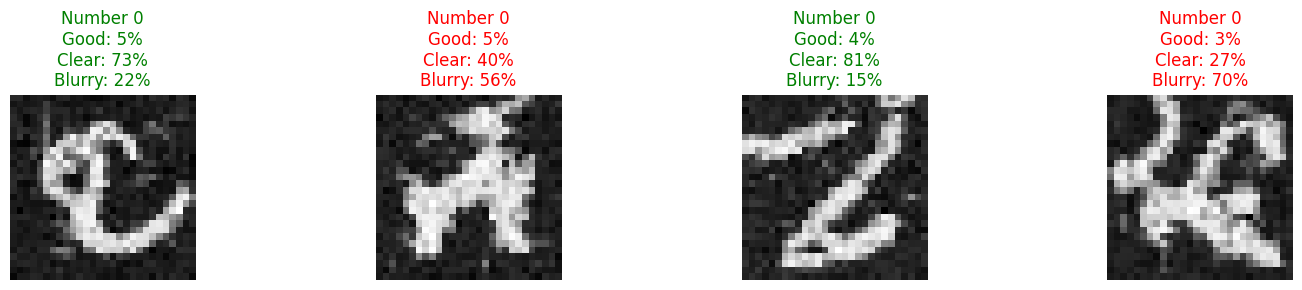


Generating and evaluating number 1...
Generating 4 versions of number 1...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


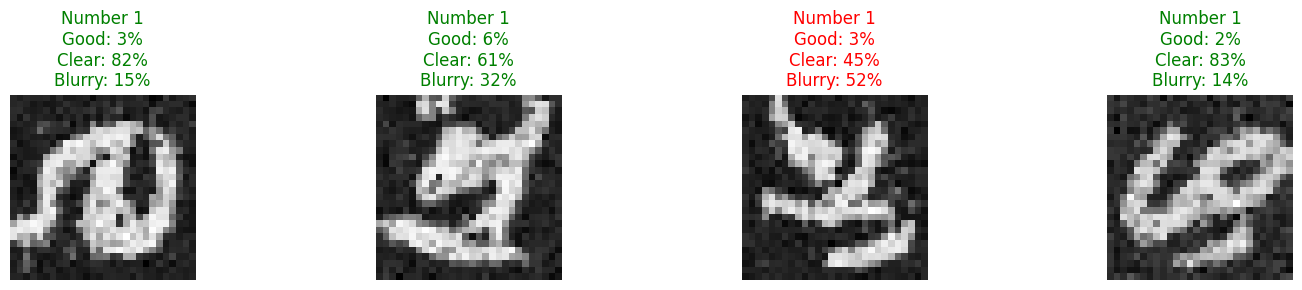


Generating and evaluating number 2...
Generating 4 versions of number 2...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


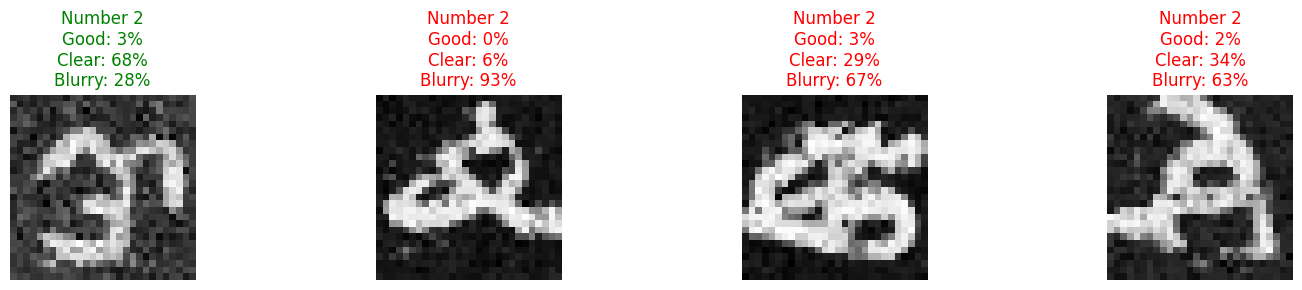


Generating and evaluating number 3...
Generating 4 versions of number 3...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


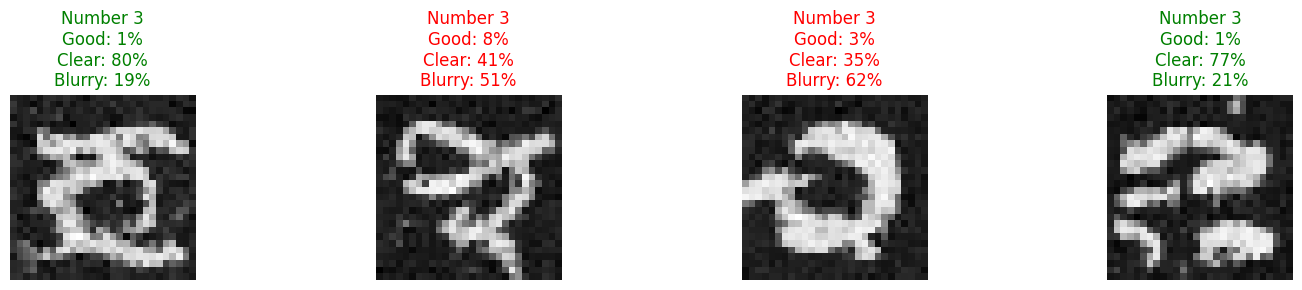


Generating and evaluating number 4...
Generating 4 versions of number 4...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


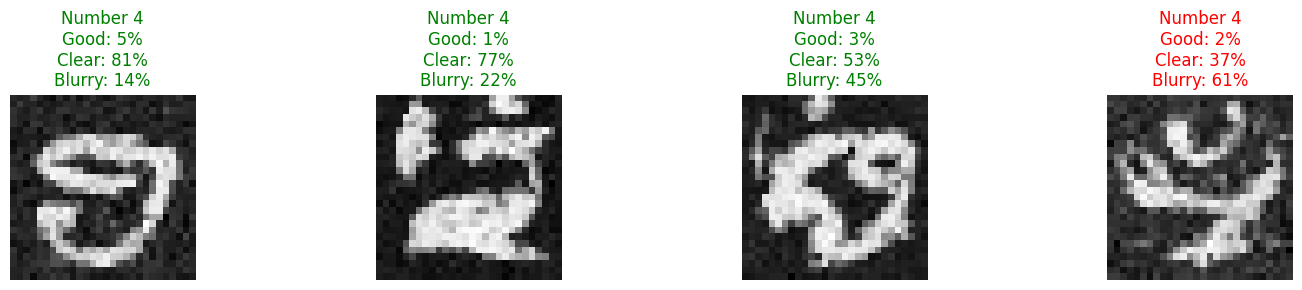


Generating and evaluating number 5...
Generating 4 versions of number 5...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


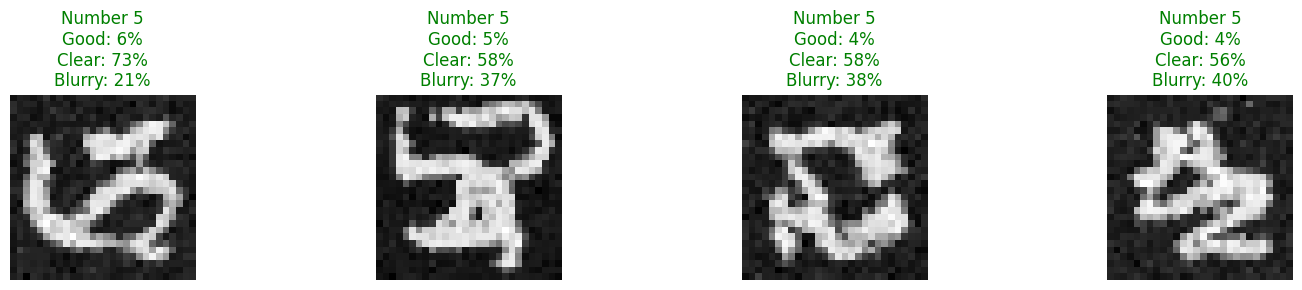


Generating and evaluating number 6...
Generating 4 versions of number 6...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


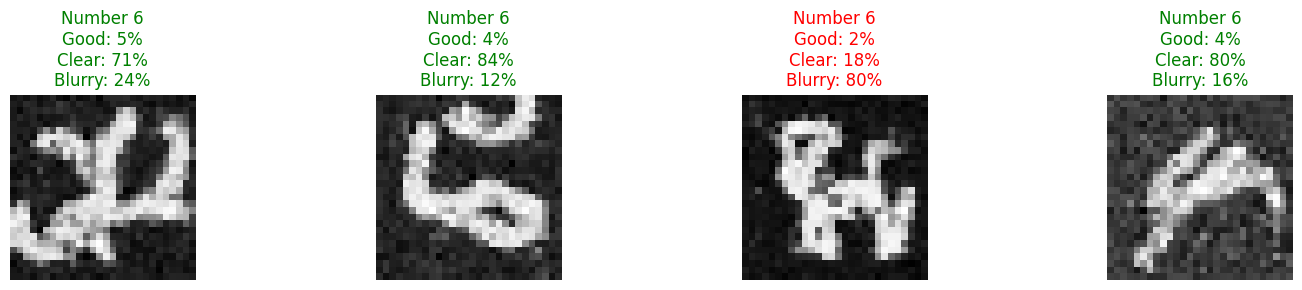


Generating and evaluating number 7...
Generating 4 versions of number 7...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


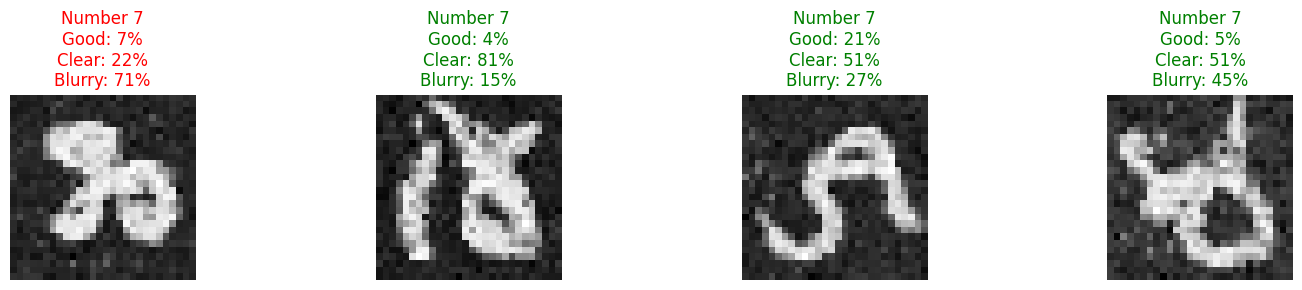


Generating and evaluating number 8...
Generating 4 versions of number 8...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


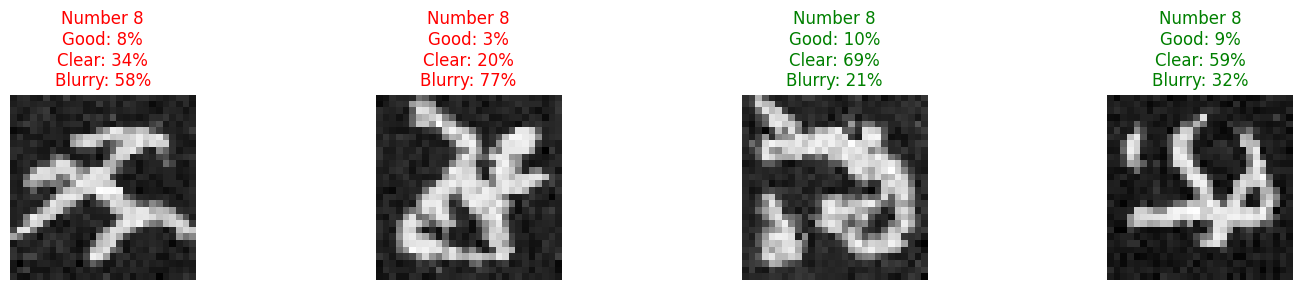


Generating and evaluating number 9...
Generating 4 versions of number 9...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


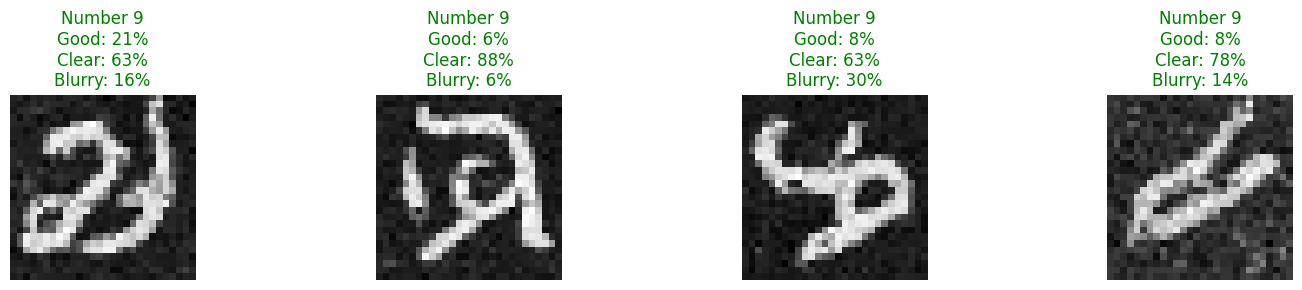


STUDENT ACTIVITY:
Try the code below to evaluate a larger sample of a specific digit

# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#     

In [ ]:
#==============================================================================
# Step 8: CLIP Model Loading and Evaluation Setup
#==============================================================================
# CLIP (Contrastive Language-Image Pre-training) is a neural network that connects
# vision and language. It was trained on 400 million image-text pairs to understand
# the relationship between images and their descriptions.
# We use it here as an "evaluation judge" to assess our generated images.

# Load CLIP model with error handling
try:
    # Load the ViT-B/32 CLIP model (Vision Transformer-based)
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    print(f"✓ Successfully loaded CLIP model: {clip_model.visual.__class__.__name__}")
except Exception as e:
    print(f"❌ Failed to load CLIP model: {e}")
    clip_available = False
    # Instead of raising an error, we'll continue with degraded functionality
    print("CLIP evaluation will be skipped. Generated images will still be displayed but without quality scores.")

def evaluate_with_clip(images, target_number, max_batch_size=16):
    """
    Use CLIP to evaluate generated images by measuring how well they match textual descriptions.

    This function acts like an "automatic critic" for our generated digits by measuring:
    1. How well they match the description of a handwritten digit
    2. How clear and well-formed they appear to be
    3. Whether they appear blurry or poorly formed

    The evaluation process works by:
    - Converting our images to a format CLIP understands
    - Creating text prompts that describe the qualities we want to measure
    - Computing similarity scores between images and these text descriptions
    - Returning normalized scores (probabilities) for each quality

    Args:
        images (torch.Tensor): Batch of generated images [batch_size, channels, height, width]
        target_number (int): The specific digit (0-9) the images should represent
        max_batch_size (int): Maximum images to process at once (prevents GPU out-of-memory errors)

    Returns:
        torch.Tensor: Similarity scores tensor of shape [batch_size, 3] with scores for:
                     [good handwritten digit, clear digit, blurry digit]
                     Each row sums to 1.0 (as probabilities)
    """
    # If CLIP isn't available, return placeholder scores
    if not clip_available:
        print("⚠️ CLIP not available. Returning default scores.")
        # Equal probabilities (0.33 for each category)
        return torch.ones(len(images), 3).to(device) / 3

    try:
        # For large batches, we process in chunks to avoid memory issues
        # This is crucial when working with big images or many samples
        if len(images) > max_batch_size:
            all_similarities = []

            # Process images in manageable chunks
            for i in range(0, len(images), max_batch_size):
                print(f"Processing CLIP batch {i//max_batch_size + 1}/{(len(images)-1)//max_batch_size + 1}")
                batch = images[i:i+max_batch_size]

                # Use context managers for efficiency and memory management:
                # - torch.no_grad(): disables gradient tracking (not needed for evaluation)
                # - torch.cuda.amp.autocast(): uses mixed precision to reduce memory usage
                with torch.no_grad(), torch.cuda.amp.autocast():
                    batch_similarities = _process_clip_batch(batch, target_number)
                    all_similarities.append(batch_similarities)

                # Explicitly free GPU memory between batches
                # This helps prevent cumulative memory buildup that could cause crashes
                torch.cuda.empty_cache()

            # Combine results from all batches into a single tensor
            return torch.cat(all_similarities, dim=0)
        else:
            # For small batches, process all at once
            with torch.no_grad(), torch.cuda.amp.autocast():
                return _process_clip_batch(images, target_number)

    except Exception as e:
        # If anything goes wrong, log the error but don't crash
        print(f"❌ Error in CLIP evaluation: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        # Return default scores so the rest of the notebook can continue
        return torch.ones(len(images), 3).to(device) / 3

def _process_clip_batch(images, target_number):
    """
    Core CLIP processing function that computes similarity between images and text descriptions.

    This function handles the technical details of:
    1. Preparing relevant text prompts for evaluation
    2. Preprocessing images to CLIP's required format
    3. Extracting feature embeddings from both images and text
    4. Computing similarity scores between these embeddings

    The function includes advanced error handling for GPU memory issues,
    automatically reducing batch size if out-of-memory errors occur.

    Args:
        images (torch.Tensor): Batch of images to evaluate
        target_number (int): The digit these images should represent

    Returns:
        torch.Tensor: Normalized similarity scores between images and text descriptions
    """
    try:
        # Create text descriptions (prompts) to evaluate our generated digits
        # We check three distinct qualities:
        # 1. If it looks like a handwritten example of the target digit
        # 2. If it appears clear and well-formed
        # 3. If it appears blurry or poorly formed (negative case)
        text_inputs = torch.cat([
            clip.tokenize(f"A handwritten number {target_number}"),
            clip.tokenize(f"A clear, well-written digit {target_number}"),
            clip.tokenize(f"A blurry or unclear number")
        ]).to(device)

        # Process images for CLIP, which requires specific formatting:

        # 1. Handle different channel configurations (dataset-dependent)
        if IMG_CH == 1:
            # CLIP expects RGB images, so we repeat the grayscale channel 3 times
            # For example, MNIST/Fashion-MNIST are grayscale (1-channel)
            images_rgb = images.repeat(1, 3, 1, 1)
        else:
            # For RGB datasets like CIFAR-10/CelebA, we can use as-is
            images_rgb = images

        # 2. Normalize pixel values to [0,1] range if needed
        # Different datasets may have different normalization ranges
        if images_rgb.min() < 0:  # If normalized to [-1,1] range
            images_rgb = (images_rgb + 1) / 2  # Convert to [0,1] range

        # 3. Resize images to CLIP's expected input size (224x224 pixels)
        # CLIP was trained on this specific resolution
        resized_images = F.interpolate(images_rgb, size=(224, 224),
                                      mode='bilinear', align_corners=False)

        # Extract feature embeddings from both images and text prompts
        # These are high-dimensional vectors representing the content
        image_features = clip_model.encode_image(resized_images)
        text_features = clip_model.encode_text(text_inputs)

        # Normalize feature vectors to unit length (for cosine similarity)
        # This ensures we're measuring direction, not magnitude
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity scores between image and text features
        # The matrix multiplication computes all pairwise dot products at once
        # Multiplying by 100 scales to percentage-like values before applying softmax
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        return similarity

    except RuntimeError as e:
        # Special handling for CUDA out-of-memory errors
        if "out of memory" in str(e):
            # Free GPU memory immediately
            torch.cuda.empty_cache()

            # If we're already at batch size 1, we can't reduce further
            if len(images) <= 1:
                print("❌ Out of memory even with batch size 1. Cannot process.")
                return torch.ones(len(images), 3).to(device) / 3

            # Adaptive batch size reduction - recursively try with smaller batches
            # This is an advanced technique to handle limited GPU memory gracefully
            half_size = len(images) // 2
            print(f"⚠️ Out of memory. Reducing batch size to {half_size}.")

            # Process each half separately and combine results
            # This recursive approach will keep splitting until processing succeeds
            first_half = _process_clip_batch(images[:half_size], target_number)
            second_half = _process_clip_batch(images[half_size:], target_number)

            # Combine results from both halves
            return torch.cat([first_half, second_half], dim=0)

        # For other errors, propagate upward
        raise e

#==============================================================================
# CLIP Evaluation - Generate and Analyze Sample Digits
#==============================================================================
# This section demonstrates how to use CLIP to evaluate generated digits
# We'll generate examples of all ten digits and visualize the quality scores

try:
    for number in range(10):
        print(f"\nGenerating and evaluating number {number}...")

        # Generate 4 different variations of the current digit
        samples = generate_number(model, number, n_samples=4)

        # Evaluate quality with CLIP (without tracking gradients for efficiency)
        with torch.no_grad():
            similarities = evaluate_with_clip(samples, number)

        # Create a figure to display results
        plt.figure(figsize=(15, 3))

        # Show each sample with its CLIP quality scores
        for i in range(4):
            plt.subplot(1, 4, i+1)

            # Display the image with appropriate formatting based on dataset type
            if IMG_CH == 1:  # Grayscale images (MNIST, Fashion-MNIST)
                plt.imshow(samples[i][0].cpu(), cmap='gray')
            else:  # Color images (CIFAR-10, CelebA)
                img = samples[i].permute(1, 2, 0).cpu()  # Change format for matplotlib
                if img.min() < 0:  # Handle [-1,1] normalization
                    img = (img + 1) / 2  # Convert to [0,1] range
                plt.imshow(img)

            # Extract individual quality scores for display
            # These represent how confidently CLIP associates the image with each description
            good_score = similarities[i][0].item() * 100  # Handwritten quality
            clear_score = similarities[i][1].item() * 100  # Clarity quality
            blur_score = similarities[i][2].item() * 100   # Blurriness assessment

            # Color-code the title based on highest score category:
            # - Green: if either "good handwritten" or "clear" score is highest
            # - Red: if "blurry" score is highest (poor quality)
            max_score_idx = torch.argmax(similarities[i]).item()
            title_color = 'green' if max_score_idx < 2 else 'red'

            # Show scores in the plot title
            plt.title(f'Number {number}\nGood: {good_score:.0f}%\nClear: {clear_score:.0f}%\nBlurry: {blur_score:.0f}%',
                      color=title_color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()  # Properly close figure to prevent memory leaks

        # Clean up GPU memory after processing each number
        # This is especially important for resource-constrained environments
        torch.cuda.empty_cache()

except Exception as e:
    # Comprehensive error handling to help students debug issues
    print(f"❌ Error in generation and evaluation loop: {e}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

    # Clean up resources even if we encounter an error
    if torch.cuda.is_available():
        print("Clearing GPU cache...")
        torch.cuda.empty_cache()

#==============================================================================
# STUDENT ACTIVITY: Exploring CLIP Evaluation
#==============================================================================
# This section provides code templates for students to experiment with
# evaluating larger batches of generated digits using CLIP.

print("\nSTUDENT ACTIVITY:")
print("Try the code below to evaluate a larger sample of a specific digit")
print("""
# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()
""")

Assessment
________________________________________
1. Understanding Diffusion (20%)
1.1 Forward diffusion process
The forward diffusion process progressively corrupts an image by adding small amounts of Gaussian noise over many timesteps. This transforms a clean image x_0into a nearly random noise sample x_T. Mathematically, it follows:
x_t=√(α ˉ_t ) x_0+√(1-α ˉ_t ) ϵ,ϵ∼N(0,I)

Each step slightly increases noise, causing the image to transition from clear and structured to blurry and finally unrecognizable. For example, MNIST digits such as “2” or “8” begin losing their structure around step 20 and appear as pure noise by step 70–100.
________________________________________
1.2 Purpose of gradual noise addition
Noise is introduced gradually to allow the network to learn denoising in small, manageable steps.
	Each timestep becomes an independent, stable learning task.
	The model learns conditional relationships between slightly noisy images rather than attempting to denoise all at once.
	This gradual process ensures stable convergence and more realistic image reconstruction during sampling.
________________________________________
1.3 Recognizability in the denoising process
During the reverse diffusion phase, images start to regain visible structure roughly after 70% of the steps are complete (around step 30 out of 100). Early timesteps remove coarse noise and recover global shapes, while later stages refine local features such as digit edges and thickness. Images become recognizable once the global structure outweighs the remaining random noise.
________________________________________


2. Model Architecture
2.1 Why U-Net architecture is effective for diffusion models
U-Net’s encoder–decoder structure, combined with skip connections, makes it highly effective for denoising tasks.
	The encoder captures high-level context and global structure.
	The decoder reconstructs fine-grained image details.
	Its multi-scale feature processing mirrors the step-by-step nature of the denoising process — from coarse restoration to fine detail refinement.
________________________________________
2.2 Importance of skip connections
Skip connections directly link encoder and decoder layers at matching spatial resolutions. They:
	Preserve high-resolution spatial features lost during downsampling.
	Improve gradient flow and training stability.
	Help restore intricate image structures such as edges, textures, and fine lines in digits.
These connections ensure that the final output retains both structural accuracy and visual sharpness.
________________________________________
2.3 Class conditioning mechanism
Class conditioning enables the model to generate images guided by class labels (e.g., digits 0–9). The process involves:
	Converting labels to one-hot vectors, then to dense embeddings using a small MLP.
	Projecting embeddings to match feature map dimensions.
	Adding or concatenating the embeddings to feature maps, typically at the bottleneck layer.
	Optionally applying a “null” token for classifier-free guidance to support both conditional and unconditional generation.
This mechanism allows the diffusion model to learn class-specific visual features, improving control over generated outputs.
________________________________________
3. Training Analysis
3.1 Interpreting the loss value
The model’s loss, calculated as the mean squared error (MSE) between predicted and actual noise, reflects how well the network learns to estimate added noise.
	A decreasing loss indicates improved denoising capability.
	A stable, low loss suggests convergence.
	Overfitting may occur if the training loss continues to drop while generated image diversity declines.
________________________________________
3.2 Image quality progression during training
	Epochs 1–5: Outputs appear as blurry blobs with little recognizable structure.
	Epochs 6–10: Coarse digit shapes begin to form, though with noticeable artifacts.
	Epoch 15 onward: Clean, clearly defined digits emerge across most classes.
This evolution demonstrates that the model first captures global patterns before refining local details.
________________________________________
3.3 Role of time embedding
Time embeddings encode the current timestep tinto a sinusoidal vector that informs the model how much noise to expect in the input. Without this information, the U-Net cannot adapt its denoising behavior for different noise levels. The embedding effectively tells the model “where we are” in the diffusion process, guiding the appropriate denoising intensity.
________________________________________
4. CLIP Evaluation
4.1 Interpretation of CLIP scores
CLIP evaluates the semantic alignment between generated images and textual descriptions.
	Higher CLIP scores indicate that the image aligns well with its intended label or prompt (e.g., “the number 7”).
	Lower scores reveal semantic ambiguity or poor alignment.
Thus, CLIP serves as an automated perceptual metric for assessing image–text correspondence.
________________________________________
4.2 Why some images are easier or harder to generate
	Easier: Classes with simple, consistent patterns (e.g., digits “1” or “0”) and low variability.
	Harder: Complex or overlapping shapes (e.g., “8” or “5”) and less frequent examples.
Variations in CLIP scores reflect differences in class complexity, data distribution, and model confidence.
________________________________________
4.3 Improving generation using CLIP scores
	Incorporate CLIP similarity as an additional loss term to balance visual and semantic quality.
	Use CLIP-guided feedback to nudge the generation process toward more accurate representations.
	Apply CLIP-based sampling techniques that steer latent trajectories toward higher semantic alignment with desired prompts.
________________________________________
5. Practical Applications
5.1 Potential real-world applications
	AI-assisted art, illustration, and concept design.
	Data augmentation for computer vision tasks with limited datasets.
	Image restoration, super-resolution, and inpainting.
	Generation of synthetic medical, satellite, or industrial data for research and training.
________________________________________
5.2 Limitations of the current model
	Requires substantial computational resources and long sampling times.
	Limited resolution and realism, especially on small datasets like MNIST.
	MSE loss encourages smooth but less sharp images.
	Restricted generalization beyond training classes.
	Ethical risks if trained on unfiltered or biased data sources.
________________________________________
5.3 Proposed improvements
	Adopt a cosine or learned noise schedule to ensure a smoother, more stable noise distribution across timesteps.
	Implement classifier-free guidance to enhance conditional accuracy and image clarity.
	Use DDIM or other accelerated sampling methods to reduce inference time (from 100 steps to as few as 20) with minimal quality degradation.
________________________________________
Summary:
This project implemented a conditional U-Net diffusion model on the MNIST dataset, demonstrated clear learning progression through training, evaluated outputs using CLIP metrics, and proposed practical enhancements for stability, speed, and semantic quality.
________________________________________



